# 데이터 분석

## 라이브러리

In [1]:
# %pip install --upgrade pip

In [2]:
## 텍스트 처리
# !pip install JPype1-1.3.0-cp39-cp39-win_amd64.whl
# !pip install konlpy
## 통계검정
#!pip install pingouin

In [3]:
# import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pingouin as pg
from scipy.stats import mannwhitneyu

import re
import sys

import itertools
from collections import Counter

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from konlpy.tag import Hannanum
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 그래프 한글폰트 출력을 위한 코드
def get_font_family():
    '''
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    '''
    import platform
    system_name = platform.system()
    # mac OS 일때
    if system_name == 'Darwin' :
        font_faimly = 'AppleGothic'
    # 윈도우일떄 
    elif system_name == 'Windows':
        font_family = 'Malgun Gothic'
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = 'NanumBarunGothic'

    return font_family

# style 설정은 꼭 폰트설정 위에서 한다. 
# style에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 깨진다.
# plt.style.use('seaborn')

#폰트설정
plt.rc('font', family=get_font_family())

#마이너스폰트 설정
plt.rc('axes', unicode_minus=False)

# 그래프에 retina display 적용
# 그래프 해상도 
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format = 'retina'

# 기업리스트

## 데이터셋 불러오기

In [5]:
# 기업 리스트 csv 불러오기
df_company_list = pd.read_csv('./input/df_company_list.csv', index_col=0)
print(df_company_list.shape)
df_company_list.head(3)

(1201, 7)


회사명   회사코드       업종 본사위치   리뷰수  평균별점  평균연봉
index                                                   
0           (주)티몬  50695  IT/웹/통신   서울  2022   2.8  4426
1          (주)위메프  60632  IT/웹/통신   서울  2003   2.6  2874
2      삼성에스디에스(주)  30162  IT/웹/통신   서울  1801   3.5  8296

In [6]:
df_company_list.tail(3)

회사명   회사코드       업종 본사위치  리뷰수  평균별점  평균연봉
index                                                   
1198        콤위즈(주)  91089  IT/웹/통신   서울   30   2.4  2794
1199       트럼피아(주)  92889  IT/웹/통신   서울   30   2.0  4144
1200   한국옐로우페이지(주)  90425  IT/웹/통신   서울   30   2.3  3058

## 기본정보 확인

### info

In [7]:
df_company_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1200
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   회사명     1201 non-null   object 
 1   회사코드    1201 non-null   int64  
 2   업종      1201 non-null   object 
 3   본사위치    1201 non-null   object 
 4   리뷰수     1201 non-null   int64  
 5   평균별점    1201 non-null   float64
 6   평균연봉    1201 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 75.1+ KB


### 결측치

In [8]:
df_company_list.isnull().sum()

회사명     0
회사코드    0
업종      0
본사위치    0
리뷰수     0
평균별점    0
평균연봉    0
dtype: int64

### 중복값
- 회사명의 코드와 회사코드의 길이가 다르다
    - 중복되는 회사명 존재
    - 회사코드를 접미사로 달아서 처리

In [9]:
# 회사명 - 회사코드 unique수가 다르다
df_company_list.nunique()

회사명     1200
회사코드    1201
업종         1
본사위치      17
리뷰수      280
평균별점      35
평균연봉    1011
dtype: int64

In [10]:
# 중복되는 회사명 검색
df_company_list[df_company_list.duplicated(subset='회사명')]

회사명   회사코드       업종 본사위치  리뷰수  평균별점  평균연봉
index                                                 
529    (주)데이타솔루션  86935  IT/웹/통신   서울   79   2.8  3556

In [11]:
# 중복데이터 전체 확인
df_company_list[df_company_list['회사명']=='(주)데이타솔루션']

회사명   회사코드       업종 본사위치  리뷰수  평균별점  평균연봉
index                                                 
484    (주)데이타솔루션  89732  IT/웹/통신   서울   87   2.6  3839
529    (주)데이타솔루션  86935  IT/웹/통신   서울   79   2.8  3556

In [12]:
# 중복데이터 + 접미사(회사코드) 처리
df_company_list['회사명'] = df_company_list.apply(lambda x: x['회사명']+'_'+ str(x['회사코드']) if x['회사명']=='(주)데이타솔루션' else x['회사명'], axis=1)

In [13]:
# 회사명 nunique 변경
df_company_list.nunique()

회사명     1201
회사코드    1201
업종         1
본사위치      17
리뷰수      280
평균별점      35
평균연봉    1011
dtype: int64

In [14]:
# 변경 완료
cond = df_company_list['회사명'].str.contains('데이타솔루션')
df_company_list[cond]

회사명   회사코드       업종 본사위치  리뷰수  평균별점  평균연봉
index                                                       
484    (주)데이타솔루션_89732  89732  IT/웹/통신   서울   87   2.6  3839
529    (주)데이타솔루션_86935  86935  IT/웹/통신   서울   79   2.8  3556

### 기타
- IT기업 데이터만 추출했으므로 `업종` 컬럼 제거
- `회사코드` 제거 

In [15]:
# df_company_list.drop(['회사코드','업종'], axis=1, inplace=True)
df_company_list.drop(['업종'], axis=1, inplace=True)

## 분석

- 서울,경기 지역에 본사가 밀집되어있다 (전체의 94% 이상)
    - 잡플래닛 리뷰데이터가 30개 이상인 IT기업 기준

In [16]:
grouped = df_company_list.value_counts('본사위치',normalize=True).reset_index(name='prop.')
grouped['누적'] = grouped['prop.'].cumsum()
grouped.head(5)

본사위치     prop.        누적
0   서울  0.810991  0.810991
1   경기  0.129892  0.940883
2   대구  0.011657  0.952540
3   부산  0.010824  0.963364
4   대전  0.010824  0.974188

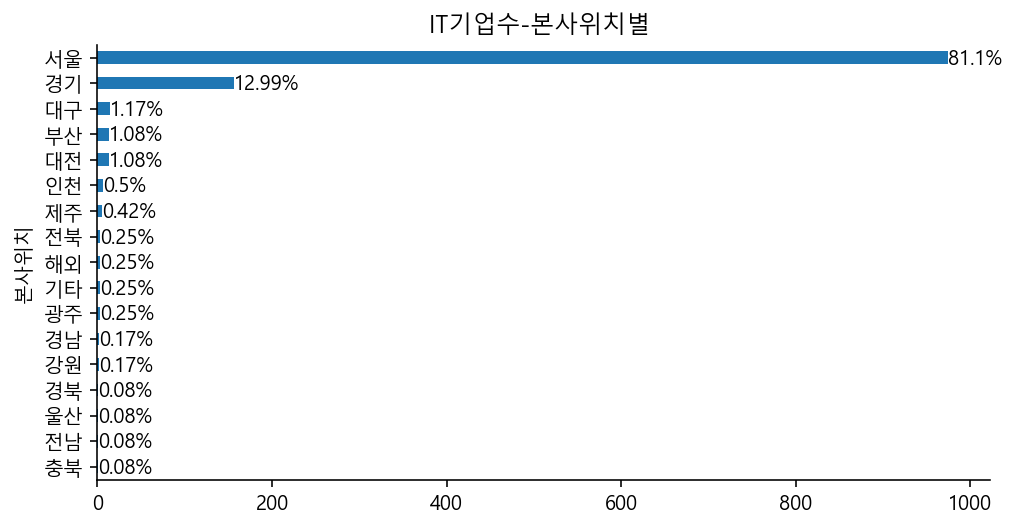

In [17]:
#시각화
plt.figure(figsize=(8,4))
grouped = df_company_list.value_counts('본사위치').sort_values()
g = grouped.plot(kind='barh')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df_company_list)*100,2)}%', (val, bar.get_y()))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.title('IT기업수-본사위치별 ')
plt.show()

- `평균별점`과 `평균연봉` 사이에 약한 양의 상관관계 존재

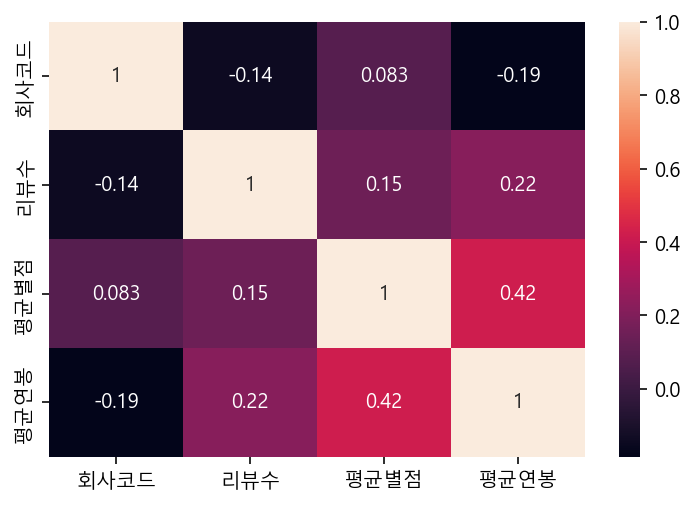

In [18]:
sns.heatmap(df_company_list.corr(), annot=df_company_list.corr());

- 기업의 평균연봉이 높을 수록 평균별점이 높아지는 경향 보인다.

In [19]:
pd.DataFrame(df_company_list['평균연봉'].describe()).T

count         mean        std     min     25%     50%     75%      max
평균연봉  1201.0  3942.243131  1354.7639  1685.0  3124.0  3666.0  4392.0  14001.0

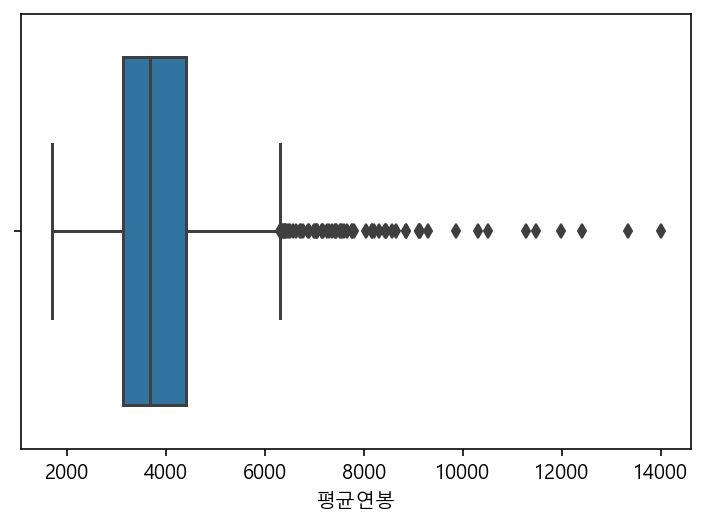

In [20]:
x='평균연봉'
sns.boxplot(x=x, data=df_company_list);

In [21]:
Q1 = df_company_list['평균연봉'].quantile(0.25)
Q3 = df_company_list['평균연봉'].quantile(0.75)
IQR = Q3-Q1

In [22]:
# 하한선이 min값 보다 아래 무시
Q1-1.5*IQR, Q3+1.5*IQR

(1222.0, 6294.0)

In [23]:
df_company_list['평균연봉그룹'] = df_company_list['평균연봉']//3000
df_company_list['평균연봉그룹']

index
0       1
1       0
2       2
3       2
4       2
       ..
1196    1
1197    1
1198    0
1199    1
1200    1
Name: 평균연봉그룹, Length: 1201, dtype: int64

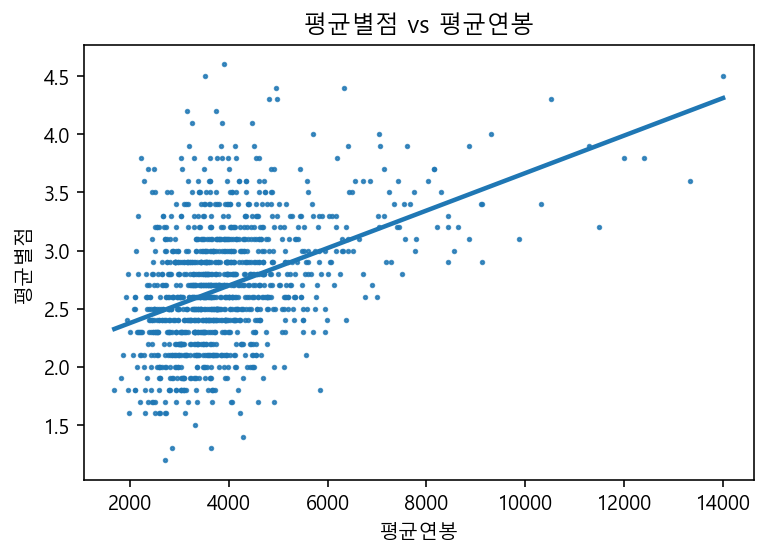

In [24]:
df = df_company_list
y='평균별점'
x='평균연봉'

sns.regplot(y=y,x=x, data=df, ci=None, scatter_kws={'s':3})
plt.title('평균별점 vs 평균연봉');

In [25]:
order = df.groupby(['본사위치'])['평균별점'].mean().sort_values(ascending=False).index

🔥
- 평균연봉이 낮은데 평점이 높은 회사는 어떤 곳인가?
- 반대로 평균연봉이 높은데 평점이 낮은 경우는?
- 특정 기업의 경우 평점조작 의혹이 있는 경우도 있음
    - 평점 조작은 어떻게 찾아내나?

In [26]:
df_company_list.sort_values('평균별점')

회사명    회사코드 본사위치  리뷰수  평균별점   평균연봉  평균연봉그룹
index                                                     
404    디자인커뮤니케이션(주)   90354   서울  100   1.2   2718       0
880         (주)세이퍼존   71842   대전   44   1.3   3639       1
786        (주)아이네임즈  183909   경기   51   1.3   2853       0
731        헤이코리안(주)   93388   서울   56   1.4   4298       1
965        아이리시스(주)  165229   서울   40   1.5   3311       1
...             ...     ...  ...  ...   ...    ...     ...
1092     (주)센드버드코리아  310768   서울   34   4.4   4946       1
666       라이엇게임즈코리아   89723   해외   62   4.4   6337       2
1185          (주)살다  356680   서울   30   4.5   3518       1
598      페이스북코리아(유)   90364   서울   71   4.5  14001       4
1051         (주)핫셀러  360493   서울   36   4.6   3900       1

[1201 rows x 7 columns]

# 리뷰데이터

## 데이터셋 불러오기

- 데이터 갱신(스크레이핑 에러 없는 버전으로 갱신)

In [27]:
df_reviews = pd.read_csv('./input/df_reviews.csv', index_col=0,  low_memory=False)
print(df_reviews.shape)
df_reviews.head(3)

(148821, 19)


회사명   회사코드        직군 전/현직원 구분 근무지역       작성월  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                          
0      티몬  50695  마케팅/시장조사      전직원   서울  2022. 04   3            5        5   
1      티몬  50695     영업/제휴      현직원   서울  2022. 04   3            5        5   
2      티몬  50695       디자인      현직원   서울  2022. 04   2            1        1   

       업무와 삶의 균형  사내문화  경영진  \
index                         
0              5     5    5   
1              5     1    1   
2              2     1    1   

                                                      총평  \
index                                                      
0                              첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사   
1      영업부서는 그나마 운영이 잘되나,  별 의미없는 콘텐츠 제작관련한 리소스가 너무 들...   
2                  하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진   

                                                      장점  \
index                                                      
0                       사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함   
1      연차사용 자유 / 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화. \n영...   
2      리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...   

                                                      단점  \
index                                                      
0       나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음   
1      동기부여도지 않는 모든것 ? / 2~3년 다니고 경험쌓기는 좋음 MD권한 많음\n대...   
2      있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...   

                                              경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  \
index                                                                         
0                                 좋은 사내문화가 만들어지면 좋을 것 같음         성장      추천   
1      신규사업을 하려면 청사진부터 그리고 방향성에 맞게 가이드라인을 만들고, 인사팀의 권...         비슷      추천   
2      사업에 대한 비전과 그를 실현시킬 수 있는 구체적인 방향을 제시해주길 원합니다모두가...        NaN     비추천   

       게시글 추천 수  
index            
0             0  
1             0  
2             0

In [28]:
df_reviews.tail(3)

회사명   회사코드        직군 전/현직원 구분 근무지역       작성월  별점  승진 기회 및 가능성  \
index                                                                        
148818  한국옐로우페이지  90425  마케팅/시장조사      전직원   서울  2015. 08   2            2   
148819  한국옐로우페이지  90425        기타      현직원   서울  2015. 03   2            3   
148820  한국옐로우페이지  90425        기타      전직원   서울  2014. 11   2            2   

        복지 및 급여  업무와 삶의 균형  사내문화  경영진                              총평  \
index                                                                   
148818        2          2     2    2  공공기관 아래에서 중소기업을 돕는 업무는 진행하는 회사   
148819        2          2     1    2               중소기업과 가까이 일하는 회사.   
148820        3          2     2    2      외국인 이면 들어가기 힘듭니다.마케팅 관심 필요   

                                        장점  \
index                                        
148818  공공기관 및 협회 업무에 대해서 직간접적인 경험을 할 수 있음   
148819         국내 다양한 중소기업을 접해볼 수 있는 기회가 됨   
148820        번역 알바생 으로 일을해봤는데 이주일에 하루만 근무   

                                              단점  \
index                                              
148818   직원의 희생에 대해서 당연시하는 경향 있으며,그 때문에 퇴사가 많은 편   
148819     요즘은 모르겠는데 예전엔 업무는 많은데 사람이 별로 없어서 힘들었음   
148820  짧은 시간 동안 많은 양으로 번역 해야되기 때문에 스트래스 많이 받습니다   

                                       경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  게시글 추천 수  
index                                                                           
148818  회사를 발전시키고 싶다면 우선 직원의 삶이 발전해야 한다는 것을 알아야 함         비슷     비추천         3  
148819                      업무배분이 효율적이면 좋을 것 같아요.         비슷     비추천         2  
148820                    별로 추천하지 않습니다. 야근 준비 해야함         비슷     비추천         0

## 기본정보 확인

### info

In [29]:
df = df_reviews.copy()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148821 entries, 0 to 148820
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   회사명          148821 non-null  object
 1   회사코드         148821 non-null  int64 
 2   직군           148649 non-null  object
 3   전/현직원 구분     148821 non-null  object
 4   근무지역         145610 non-null  object
 5   작성월          148730 non-null  object
 6   별점           148821 non-null  int64 
 7   승진 기회 및 가능성  148821 non-null  int64 
 8   복지 및 급여      148821 non-null  int64 
 9   업무와 삶의 균형    148821 non-null  int64 
 10  사내문화         148821 non-null  int64 
 11  경영진          148821 non-null  int64 
 12  총평           148820 non-null  object
 13  장점           148821 non-null  object
 14  단점           148821 non-null  object
 15  경영진에 바라는 점   148733 non-null  object
 16  1년 후 기업 전망   104781 non-null  object
 17  기업 추천여부      148821 non-null  object
 18  게시글 추천 수     148821 non-null  int64 
dtypes:

### 결측치

In [31]:
df.isnull().sum()

회사명                0
회사코드               0
직군               172
전/현직원 구분           0
근무지역            3211
작성월               91
별점                 0
승진 기회 및 가능성        0
복지 및 급여            0
업무와 삶의 균형          0
사내문화               0
경영진                0
총평                 1
장점                 0
단점                 0
경영진에 바라는 점        88
1년 후 기업 전망     44040
기업 추천여부            0
게시글 추천 수           0
dtype: int64

- 1년 후 기업 전망 데이터가 비어있는 경우가 많다.

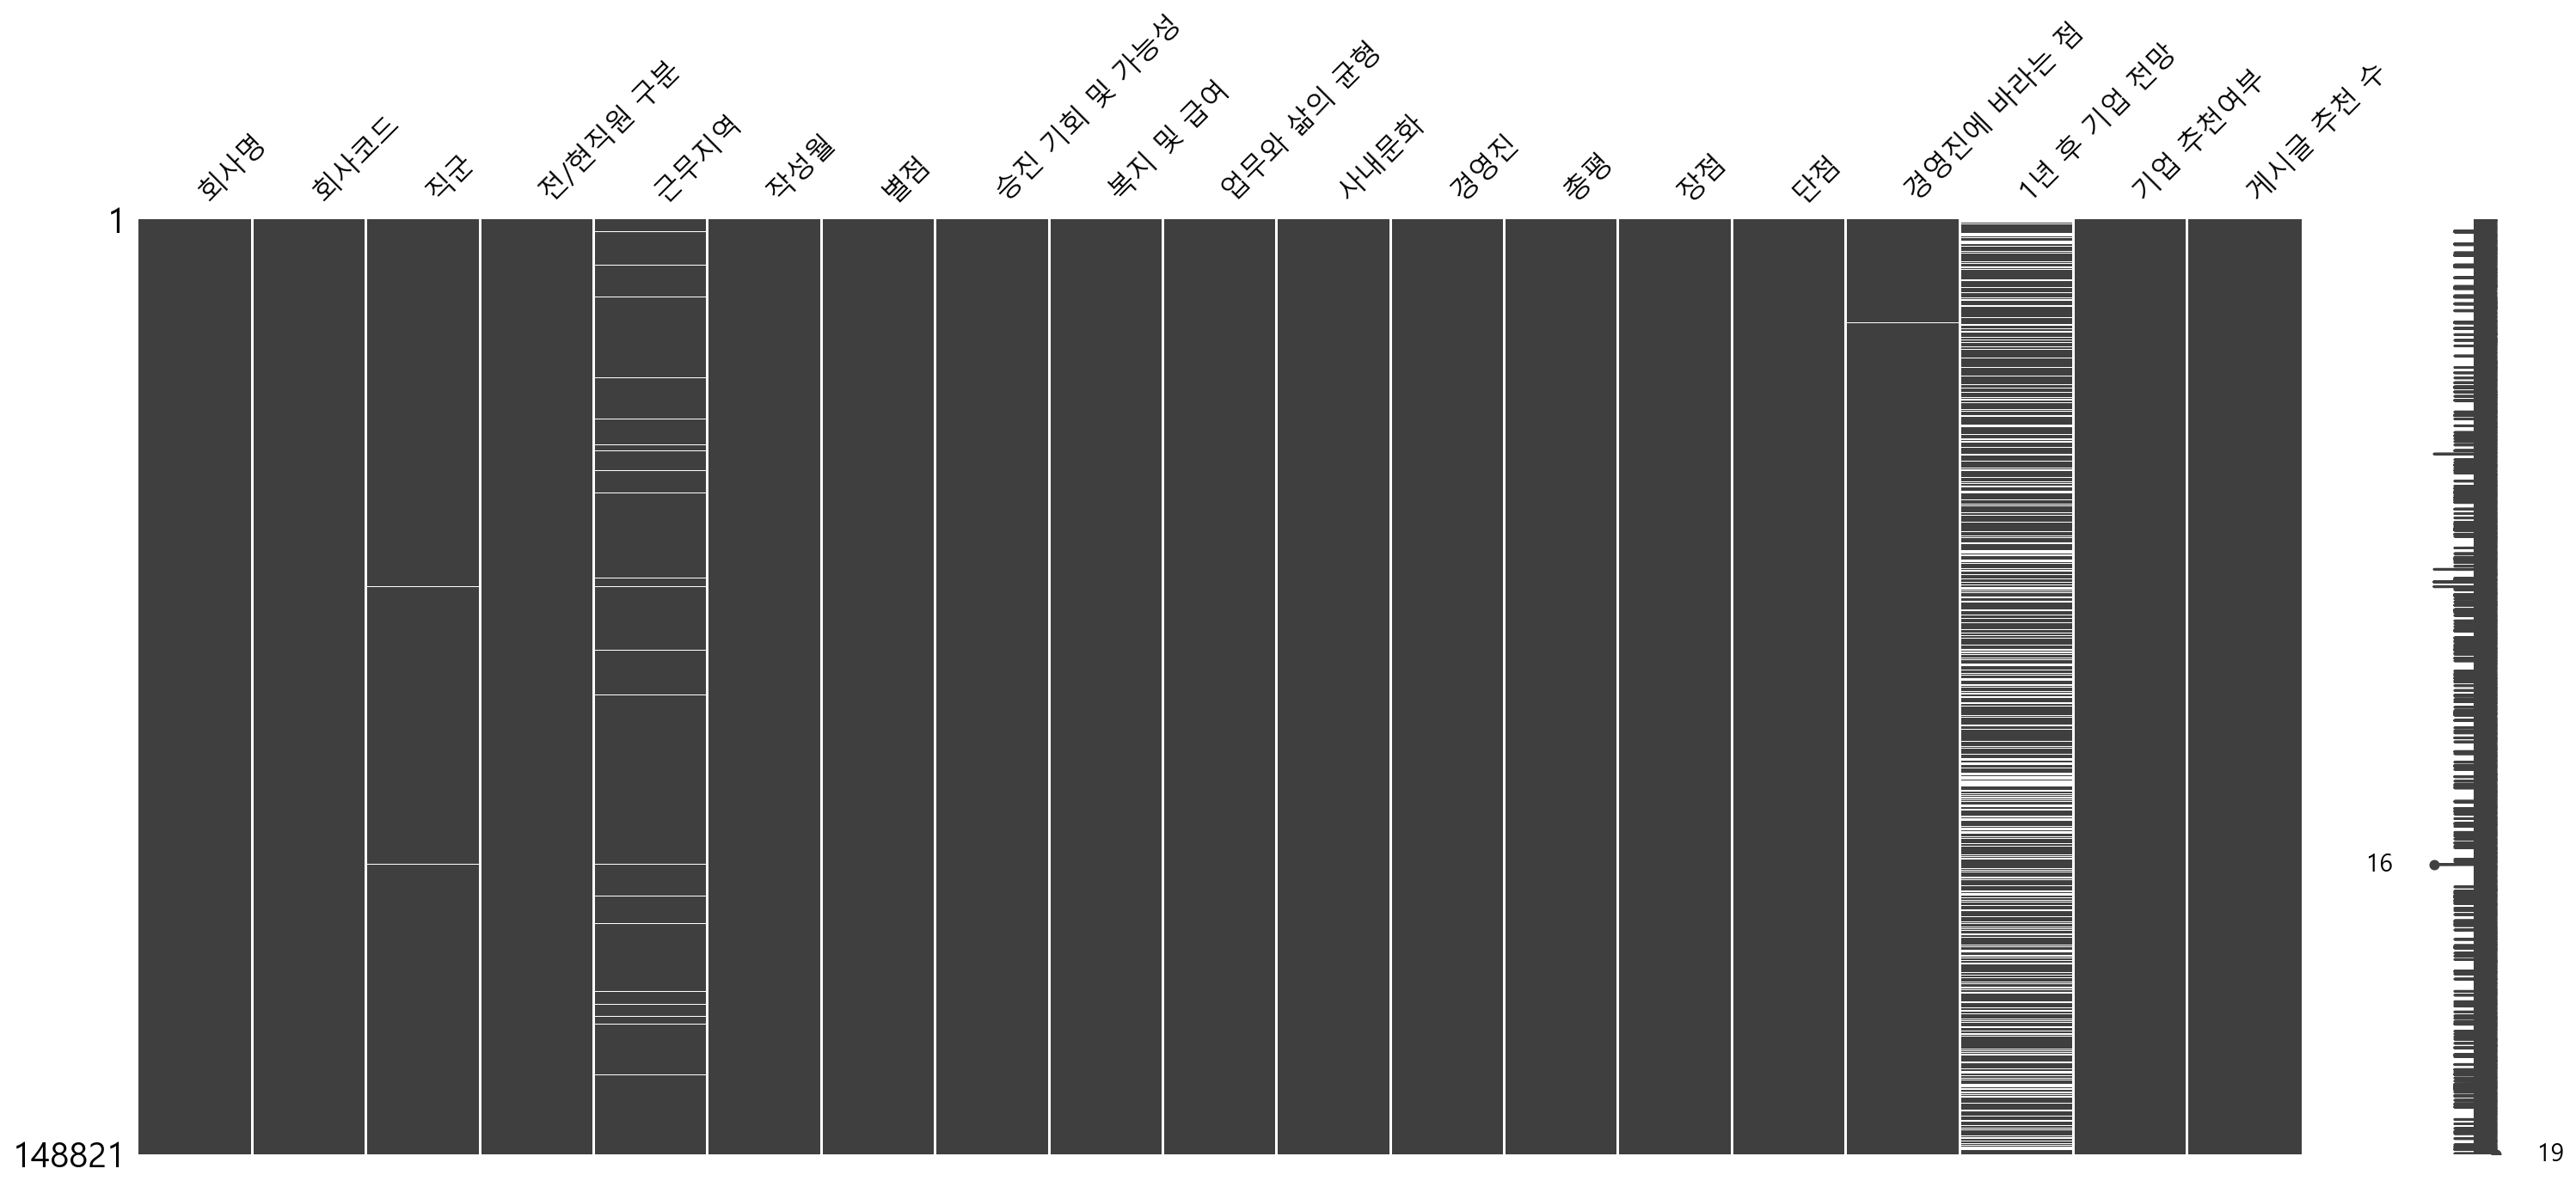

In [32]:
msno.matrix(df);

- 결측치 unknown 대체

In [33]:
df = df.fillna('unknown')
df.isnull().sum()

회사명            0
회사코드           0
직군             0
전/현직원 구분       0
근무지역           0
작성월            0
별점             0
승진 기회 및 가능성    0
복지 및 급여        0
업무와 삶의 균형      0
사내문화           0
경영진            0
총평             0
장점             0
단점             0
경영진에 바라는 점     0
1년 후 기업 전망     0
기업 추천여부        0
게시글 추천 수       0
dtype: int64

### 중복값

- 스크레이핑 과정에서 중복값 8개 발생 -> 제거

In [34]:
df.duplicated().sum()

8

In [35]:
# 중복값 제거
print('제거 전:',df.shape)
df = df.drop_duplicates()
print('제거 후:',df.shape)

제거 전: (148821, 19)
제거 후: (148813, 19)


- 하기 총 4개 기업에 대하여 회사코드를 접미사로 붙여 중복값문제 해결
    - 데이타솔루션 -> 기업리스트와 똑같은 문제
    - (주)유시스, 유시스(주) -> (주) 제거되면서 해당 문제 발생

In [36]:
grouped = df.groupby(['회사명','회사코드']).size().reset_index().drop(0, axis=1)
grouped[grouped.duplicated('회사명', keep=False)]

회사명   회사코드
126  데이타솔루션  86935
127  데이타솔루션  89732
759     유시스  59945
760     유시스  59946

In [37]:
# 중복값되는 회사명에 접미사 추가 
df['회사명'] = df.apply(lambda x: x['회사명']+'_'+ str(x['회사코드']) if x['회사명']=='데이타솔루션' or x['회사명']=='유시스' else x['회사명'], axis=1)

In [38]:
grouped = df.groupby(['회사명','회사코드']).size().reset_index().drop(0, axis=1)
grouped[grouped.duplicated('회사명', keep=False)]

Empty DataFrame
Columns: [회사명, 회사코드]
Index: []

In [39]:
# 변경된 회사명 확인
df[df['회사명'].str.contains('데이타솔루션')]['회사명'].unique()

array(['데이타솔루션_89732', '데이타솔루션_86935'], dtype=object)

In [40]:
df[df['회사명'].str.contains('유시스')]['회사명'].unique()

array(['유시스_59946', '유시스_59945'], dtype=object)

### 기타 
- `회사코드` 제거

In [41]:
# df.drop('회사코드', axis=1, inplace=True)

## 전처리

### `직군`

- 'IT-인터넷' -> 'IT/인터넷' 으로 통일

In [42]:
df['직군'].unique()

array(['마케팅/시장조사', '영업/제휴', '디자인', 'IT/인터넷', '서비스/고객지원', '경영/기획/컨설팅',
       '유통/무역', '생산관리/품질관리', '교육', '미디어/홍보', '인사/총무', '금융/재무', '생산/제조',
       '전문직', '법률/법무', '기타', '연구개발', '엔지니어링', '의약', '특수계층/공공', 'IT-인터넷',
       'unknown'], dtype=object)

In [43]:
df['직군'] = df['직군'].apply(lambda x:x.replace('-','/') if not isinstance(x, float) else x)
df['직군'].unique()

array(['마케팅/시장조사', '영업/제휴', '디자인', 'IT/인터넷', '서비스/고객지원', '경영/기획/컨설팅',
       '유통/무역', '생산관리/품질관리', '교육', '미디어/홍보', '인사/총무', '금융/재무', '생산/제조',
       '전문직', '법률/법무', '기타', '연구개발', '엔지니어링', '의약', '특수계층/공공', 'unknown'],
      dtype=object)

### `작성월`
- 불량 데이터 -> 결측치 변환 
    - '이 기업의 댓글' -> 'unknown'

In [44]:
df['작성월'].unique()

array(['2022. 04', '2022. 03', '2022. 02', '2022. 01', '2021. 12',
       '2021. 11', '2021. 10', '2021. 09', '2021. 08', '2021. 07',
       '2021. 06', '2021. 05', '2021. 04', '2021. 03', '2021. 02',
       '2021. 01', '2020. 12', '2020. 11', '2020. 10', '2020. 09',
       '2020. 08', '2020. 07', '2020. 06', '2020. 05', '2020. 04',
       '2020. 03', '2020. 02', '2020. 01', '2019. 12', '2019. 11',
       '2019. 10', '2019. 09', '2019. 08', '2019. 07', '2019. 06',
       '2019. 05', '2019. 04', '2019. 03', '2019. 02', '2019. 01',
       '2018. 12', '2018. 11', '2018. 10', '2018. 09', '2018. 08',
       '2018. 07', '2018. 06', '2018. 05', '2018. 04', '2018. 03',
       '2018. 02', '2018. 01', '2017. 12', '2017. 11', '2017. 10',
       '2017. 09', '2017. 08', '2017. 07', '2017. 06', '2017. 05',
       '2017. 04', '2017. 03', '2017. 02', '2017. 01', '2016. 12',
       '2016. 11', '2016. 10', '2016. 09', '2016. 08', '2016. 07',
       '2016. 06', '2016. 05', '2016. 04', '2016. 03', '2016. 

In [45]:
# 스크레이핑 에러 제거
df['작성월'] = np.where(df['작성월']=='이 기업의 댓글', 'unknown', df['작성월'])
df['작성월'].unique()

array(['2022. 04', '2022. 03', '2022. 02', '2022. 01', '2021. 12',
       '2021. 11', '2021. 10', '2021. 09', '2021. 08', '2021. 07',
       '2021. 06', '2021. 05', '2021. 04', '2021. 03', '2021. 02',
       '2021. 01', '2020. 12', '2020. 11', '2020. 10', '2020. 09',
       '2020. 08', '2020. 07', '2020. 06', '2020. 05', '2020. 04',
       '2020. 03', '2020. 02', '2020. 01', '2019. 12', '2019. 11',
       '2019. 10', '2019. 09', '2019. 08', '2019. 07', '2019. 06',
       '2019. 05', '2019. 04', '2019. 03', '2019. 02', '2019. 01',
       '2018. 12', '2018. 11', '2018. 10', '2018. 09', '2018. 08',
       '2018. 07', '2018. 06', '2018. 05', '2018. 04', '2018. 03',
       '2018. 02', '2018. 01', '2017. 12', '2017. 11', '2017. 10',
       '2017. 09', '2017. 08', '2017. 07', '2017. 06', '2017. 05',
       '2017. 04', '2017. 03', '2017. 02', '2017. 01', '2016. 12',
       '2016. 11', '2016. 10', '2016. 09', '2016. 08', '2016. 07',
       '2016. 06', '2016. 05', '2016. 04', '2016. 03', '2016. 

- 년.월 -> 년도 only로 처리
- 컬럼명 변경 
    - '작성월' -> '작성년도'

In [46]:
df['작성월'] = df['작성월'].apply(lambda x:x.split('. ')[0])
df = df.rename(columns={'작성월':'작성년도'})
df.head(1)

회사명   회사코드        직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                      
0      티몬  50695  마케팅/시장조사      전직원   서울  2022   3            5        5   

       업무와 삶의 균형  사내문화  경영진                         총평  \
index                                                    
0              5     5    5  첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사   

                                     장점  \
index                                     
0      사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함   

                                                     단점  \
index                                                     
0      나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음   

                   경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  게시글 추천 수  
index                                                       
0      좋은 사내문화가 만들어지면 좋을 것 같음         성장      추천         0

In [47]:
df['작성년도'].unique()

array(['2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015',
       '2014', 'unknown'], dtype=object)

In [48]:
# unknown 제거, 자료형 int 타입으로 변경
cond = df['작성년도'] == 'unknown'
df = df[~cond]
df['작성년도'] = df['작성년도'].astype(int)

## 분석

### `직군`

- IT/인터넷 직군이 전체 리뷰 작성자의 58.17% 차지 
    - IT직군 여부에 따른 점수 차이 있을까?
- 다음으로 경영/기획/컨설팅(8.16%), 영업/제휴(6.80%) 순

🔥
- 상세직군이 나오면 분석이 더 용이할것 같은데, 상세하게 적으면 누군지 추적이 되니까 상세하게 기재하지 못할 것 같다. 
- 직군을 가짜로 기재한 경우도 있을까? 혹시나 모를 추적이 두려워서

In [49]:
grouped = pd.DataFrame(df['직군'].value_counts())
grouped['비율(%)'] = df['직군'].value_counts(normalize=True).round(4)*100
grouped.head(10)

직군  비율(%)
IT/인터넷     86479  58.17
경영/기획/컨설팅  12125   8.16
영업/제휴      10116   6.80
마케팅/시장조사    9692   6.52
디자인         7906   5.32
서비스/고객지원    7351   4.94
미디어/홍보      3140   2.11
인사/총무       1975   1.33
금융/재무       1690   1.14
교육          1557   1.05

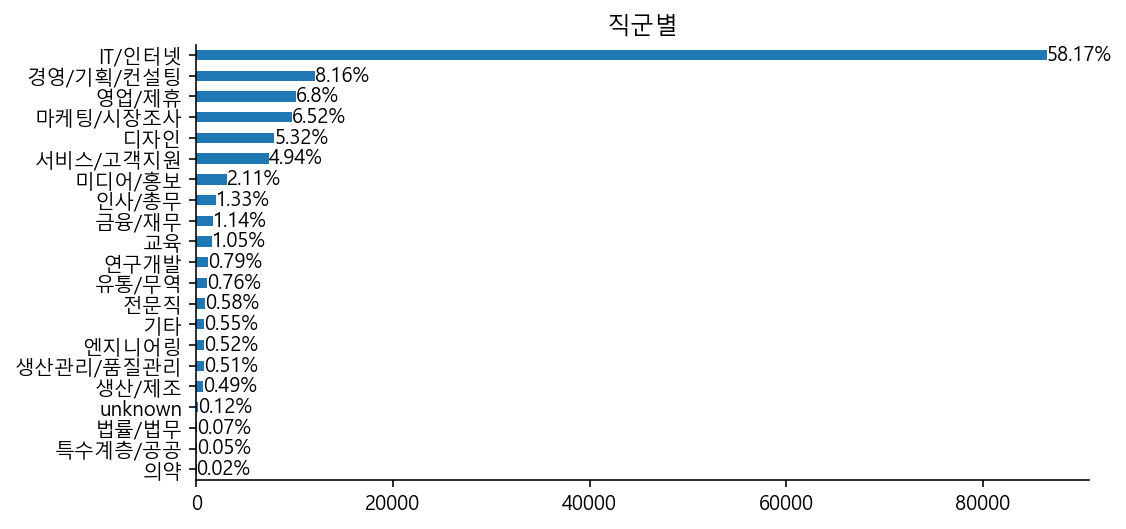

In [50]:
#시각화
x = '직군'
grouped = df['직군'].value_counts().sort_values()

plt.figure(figsize=(8,4))
g = grouped.plot(kind='barh')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df)*100,2)}%', (val, bar.get_y()))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.title('직군별')
plt.show()

- 가설 : IT직군의 만족도가 비IT 직군에 비해 높을 것이다. 

In [51]:
# IT여부 컬럼 생성
cond = df['직군'] == 'IT/인터넷'
df['IT여부'] = np.where(cond, 'IT', '비IT')
df.head(1)

회사명   회사코드        직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                      
0      티몬  50695  마케팅/시장조사      전직원   서울  2022   3            5        5   

       업무와 삶의 균형  사내문화  경영진                         총평  \
index                                                    
0              5     5    5  첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사   

                                     장점  \
index                                     
0      사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함   

                                                     단점  \
index                                                     
0      나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음   

                   경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  게시글 추천 수 IT여부  
index                                                            
0      좋은 사내문화가 만들어지면 좋을 것 같음         성장      추천         0  비IT

- countplot
    - IT직군의 비율이 높다.
    - 비IT 직군의 비율이 높아지는 추세

In [52]:
# count plot 함수
def countplot(hue):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    order = sorted(df[hue].unique())
    g = sns.countplot(data=df, x=hue, order=order, ax=ax[0])

    for p in g.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(df))
        x = p.get_x() + p.get_width()
        y = p.get_height()
        g.annotate(percentage, (x-0.4, y), ha='center', va='bottom')
    
    sns.despine()
    ax[0].set_title(f'{hue} count - 전체')
    
    x='작성년도'
    sns.histplot(x=x,  data=df,  discrete=True, hue=hue, hue_order=order, multiple='fill', ax=ax[1])
    ax[1].set_title(f'{hue} count - 연도별')
    
    plt.show()

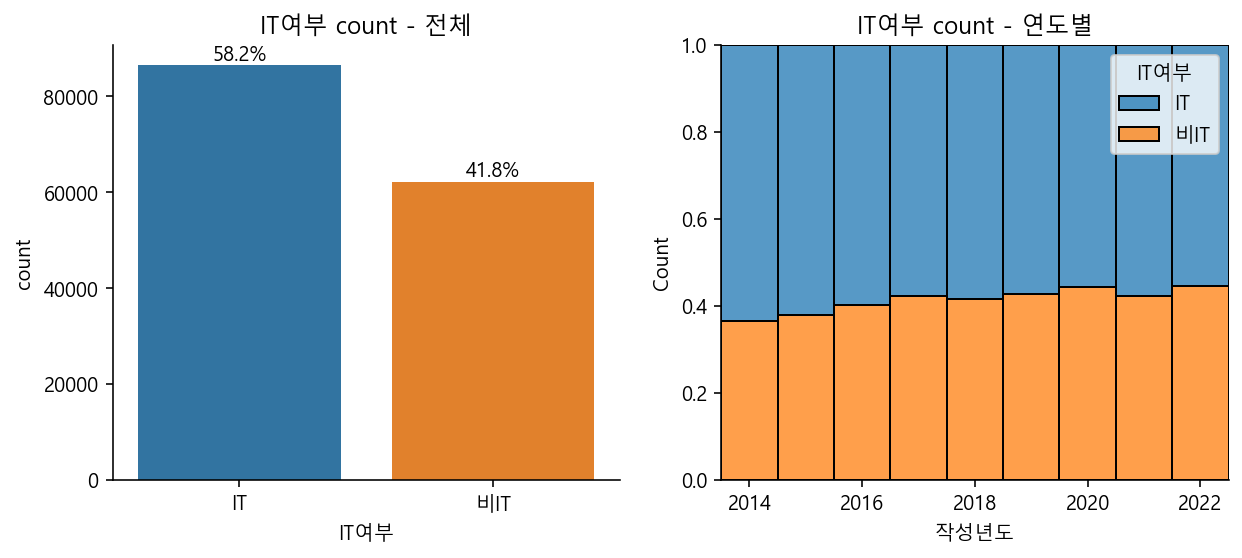

In [53]:
countplot('IT여부')

- histplot

In [54]:
# histplot 생성함수 생성
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']
def histplot(hue=None):
    fig,ax = plt.subplots(2, 3, figsize=(15,7))
    for idx, col in enumerate(arr_scores):
        x = col
        r,c = idx//3, idx%3
        if hue == None: 
            g = sns.histplot(x=x, data=df, discrete=True, 
                             hue=hue, ax=ax[r,c], 
                             stat="density", common_norm=False)
            g.set_title(col)
        else: 
            order = sorted(df[hue].unique())
            g = sns.histplot(x=x, data=df, discrete=True, 
                             hue=hue, hue_order=order, ax=ax[r,c], 
                             stat="density", common_norm=False)
            g.set_title(f'{hue}에 따른 - {col} 분포')
        
    plt.tight_layout()
    plt.show()

- 6가지 항목에 대한 전체 점수분포
    1. 모든 항목에서 5점에 대한 분포가 가장 적다. 
    2. 경영진 점수 - 1점이 가장 높다.
        - 서비스 이용자 연령대와 상관이 있을까?
        - 20~30대 사용자가 주 사용자로 추측되는데 경영진에 대한 불만이 많아서?

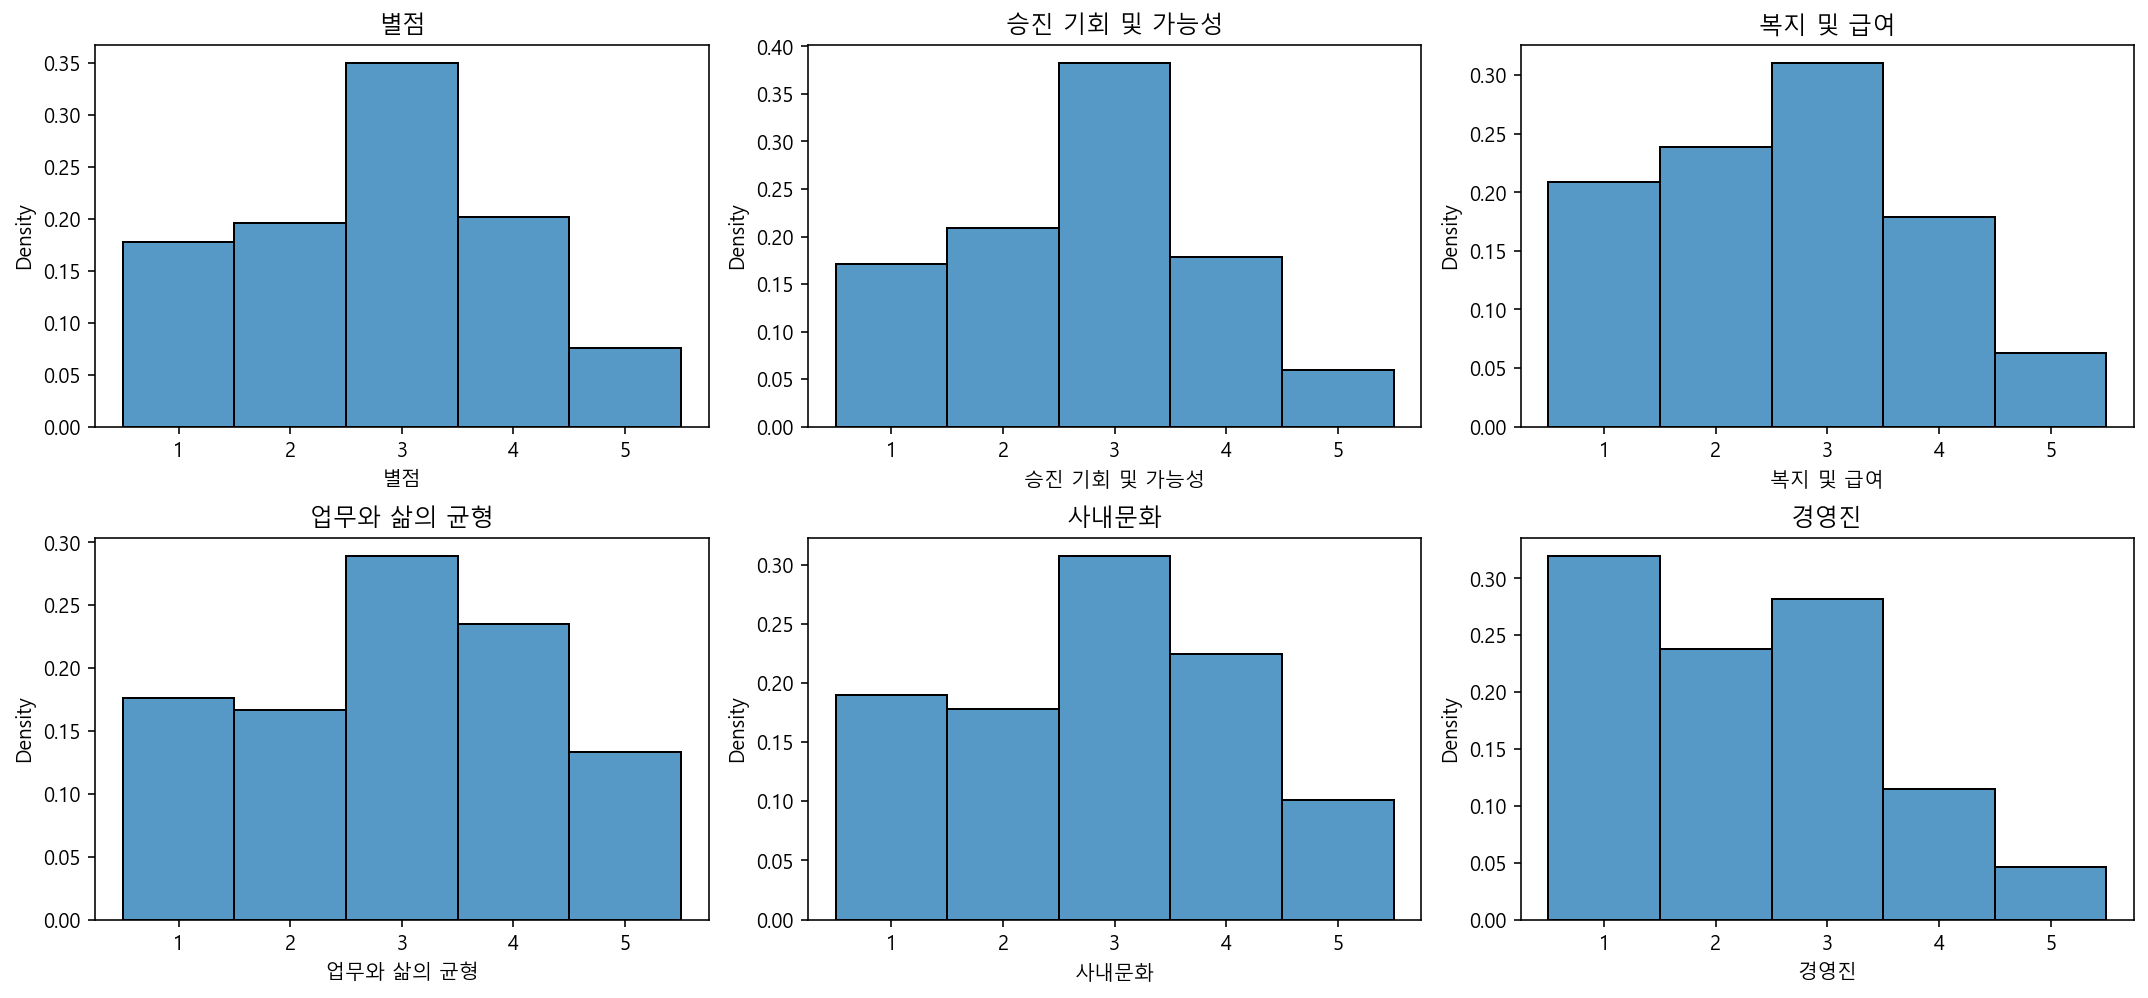

In [55]:
histplot()

- IT직군 여부에 따른 점수 분포
    - IT 직군
        - 경영진에 대한 불만(1~2점)이 비 IT직군에 비해 더 크다
    - 비IT직군
        - 승진 기회 및 가능성 / 업무와 삶의 균형 2가지 항목에서 1점의 분포가 더 크다.

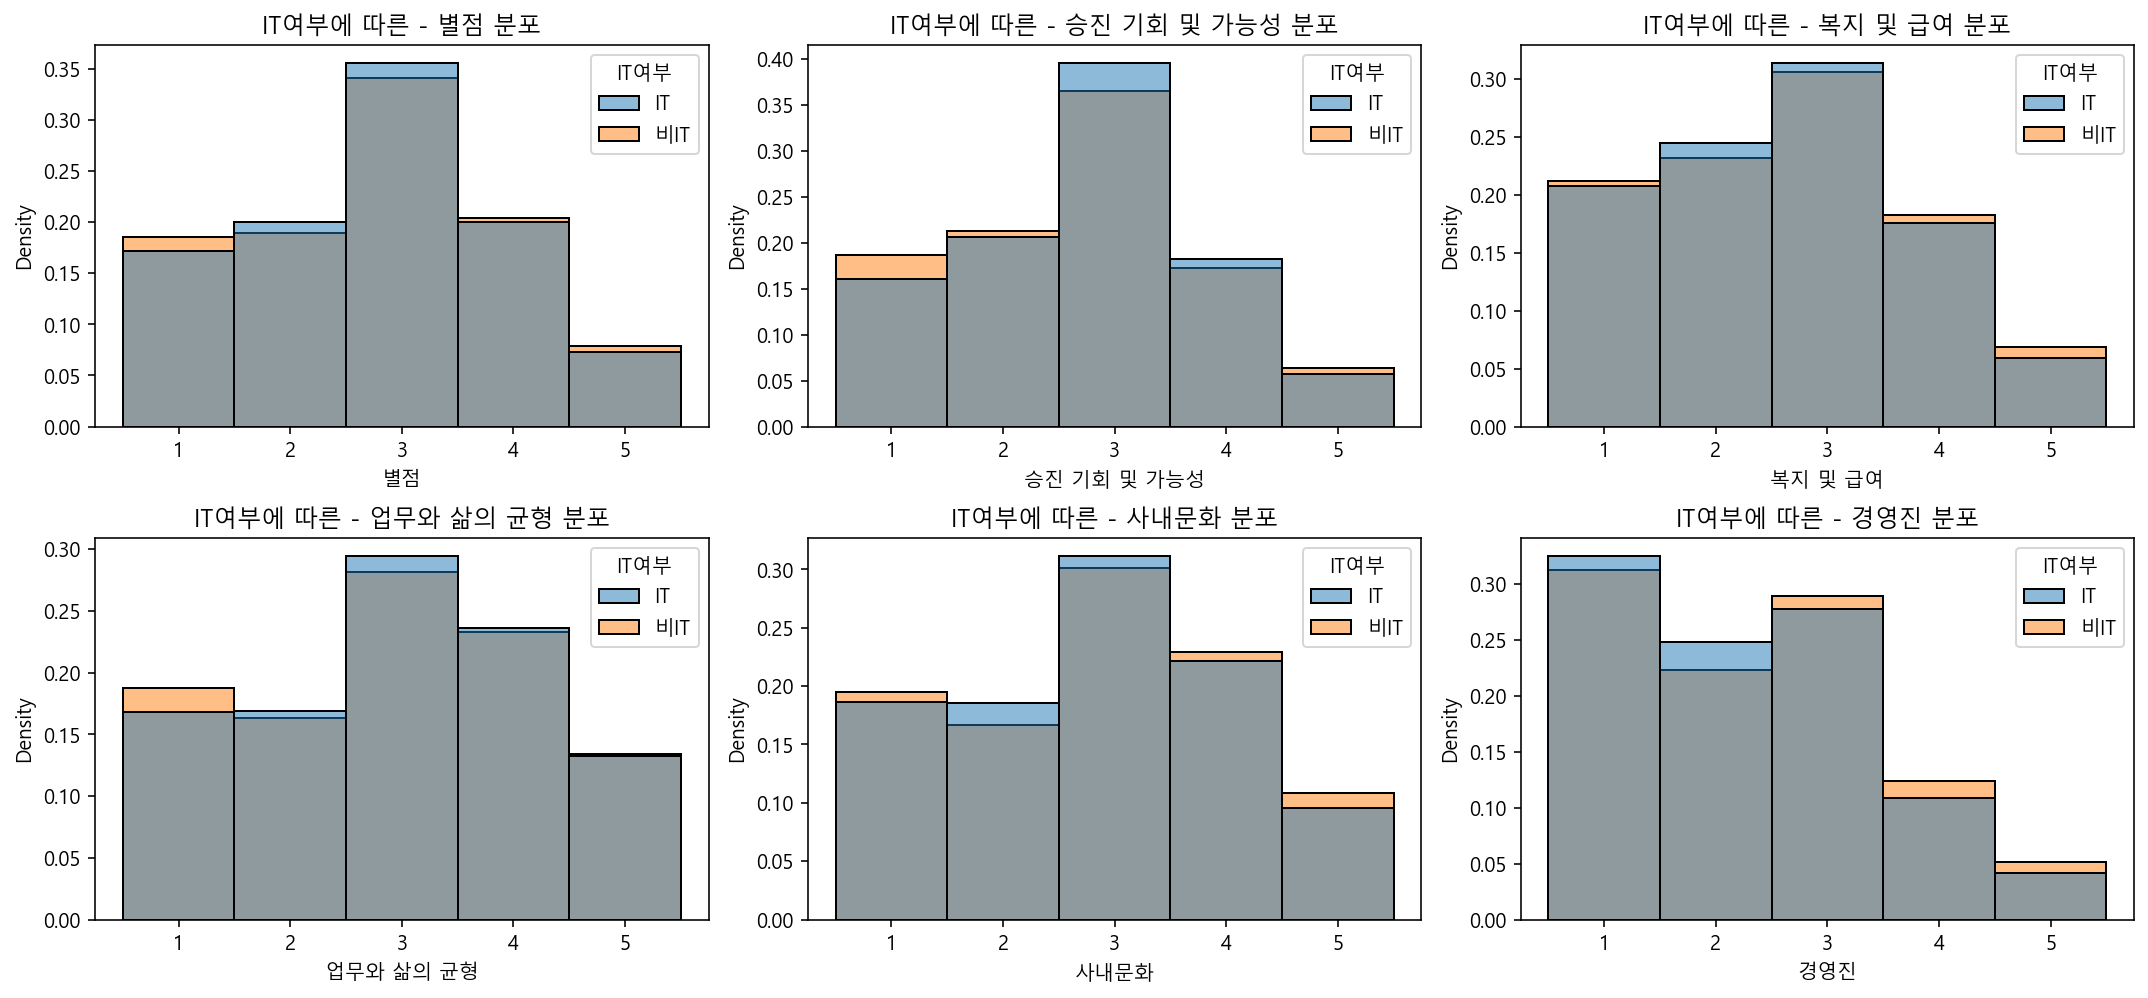

In [56]:
histplot('IT여부')

In [57]:
# melting table 함수 생성 
arr_scores = ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']
def melting_table(id_vars, value_vars=arr_scores):
    tmp = df[[id_vars]+value_vars]
    melted = tmp.melt(id_vars=id_vars, value_vars=value_vars, var_name='항목', value_name='점수')
    return melted

In [58]:
melted = melting_table('IT여부')
grouped = melted.groupby(['IT여부','항목'])['점수'].mean().reset_index()
grouped.head(6)

IT여부           항목        점수
0   IT          경영진  2.294777
1   IT           별점  2.802114
2   IT      복지 및 급여  2.634894
3   IT         사내문화  2.853652
4   IT  승진 기회 및 가능성  2.770557
5   IT    업무와 삶의 균형  2.996462

- point plot
    - 별점의 차이는 크게 보이지 않고
    - **승진기회 및 가능성, 업무와 삶의 균형 -> IT가 높음**
    - 복지 및 급여, 사내문화, 경영진 -> 비IT가 높음
        - **IT직군의 급여가 비IT직군에 비해 높을텐데 복지 및 급여점수가 더 낮은게 의외다.**
    - **경영진에 대한 평균 점수 매우 낮다**
    - IT vs 비IT 연봉 비교 테이블 구할 수 있으려나

In [59]:
# point plot 생성함수
def pointplot(hue=None):
    melted = melting_table(hue)
    grouped = melted.groupby([hue,'항목'])['점수'].mean().reset_index()
    order = sorted(df[hue].unique())
    g = sns.pointplot(data=grouped, y='점수',x='항목', hue=hue, hue_order=order, order=arr_scores)
    plt.title(f'{hue}에 따른 평균 점수')
    plt.xticks(rotation=20)
    sns.despine()
    plt.show()

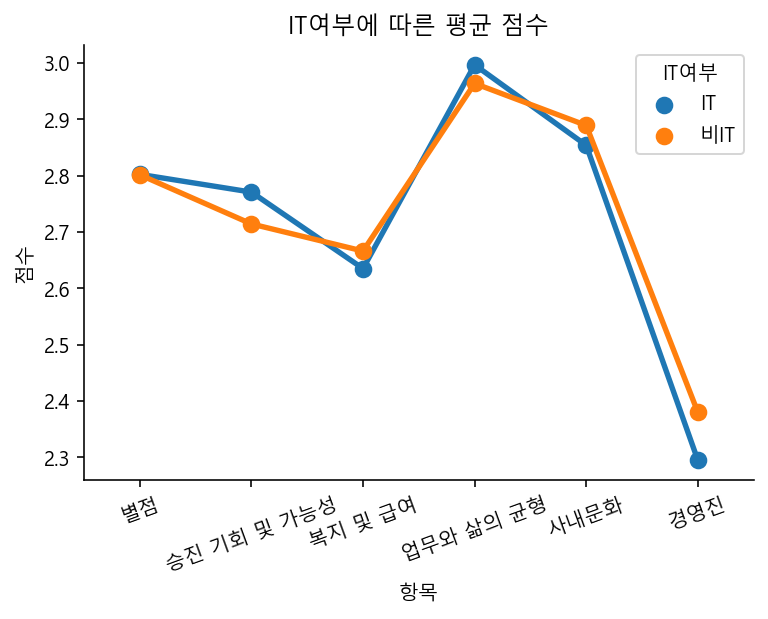

In [60]:
pointplot('IT여부')

- radar plot
    - 비IT 직군의 경영진 점수가 살짝 더 높아보이긴 하지만
    - point plot으로 볼때보다 두 그룹간의 큰 차이가 안보인다.
    - 통계검정으로 비교 해보자    

In [61]:
# radar plot 생성함수 
def radarplot(hue=None):
    melted = melting_table(hue) # melting함수 사용
    grouped = melted.groupby([hue,'항목'])['점수'].mean().reset_index().sort_values('항목')

    categories = list(grouped['항목'].unique())
#     categories.remove('별점')
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2*np.pi, num=len(categories))
    
    plt.figure(figsize=(5,5))
    ax = plt.subplot(polar=True)

    plt.xticks(label_loc, labels=categories, fontsize=10)
    
    for h_val in sorted(grouped[hue].unique()):
        cond = grouped[hue] == h_val
        grade = list(grouped[cond]['점수'])
        grade = [*grade, grade[0]]
        
        ax.plot(label_loc, grade, label=h_val, lw=1, marker='o', ms=4)
        ax.fill(label_loc, grade, alpha=0.1)
    
    ax.legend(loc='center')
    ax.set_title(f'{hue}에 따른 평균 점수', fontsize=13)


    plt.show()

In [62]:
def radarplot(hue=None):
    melted = melting_table(hue) # melting함수 사용
    grouped = melted.groupby([hue,'항목'])['점수'].mean().reset_index().sort_values('항목')

    categories = list(grouped['항목'].unique())
#     categories.remove('별점')
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2*np.pi, num=len(categories))
    
    plt.figure(figsize=(5,5))
    ax = plt.subplot(polar=True)

    plt.xticks(label_loc, labels=categories, fontsize=10)
    
    for h_val in sorted(grouped[hue].unique()):
        cond = grouped[hue] == h_val
        grade = list(grouped[cond]['점수'])
        grade = [*grade, grade[0]]
        
        ax.plot(label_loc, grade, label=h_val, lw=1, marker='o', ms=4)
        ax.fill(label_loc, grade, alpha=0.1)
    
    ax.legend(loc='center')
    ax.set_title(f'{hue}에 따른 평균 점수', fontsize=13)


    plt.show()

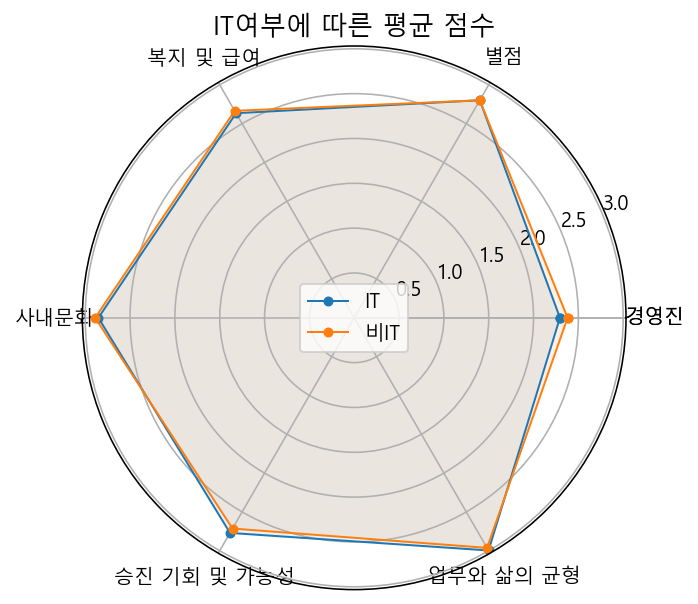

In [63]:
radarplot('IT여부')

- 비 모수적 검정
    - Wilcoxon-Mann-Whitney
    - 별점의 경우, 범주-순서 자료형
    - 참고 - https://bioinformaticsandme.tistory.com/111
    
    - pointplot에서 보이는 결과와 같다. 

In [64]:
# # levene test 함수 설정 (무시 - 모수검정용)
# def levene(hue_var, hue_val):
#     # 그룹 분할
#     cond = df[hue_var] == hue_val
#     df_a = df[cond][arr_scores]
#     df_b = df[~cond][arr_scores]
    
#     # 점수항목별 test
#     for col in arr_scores:
#         lev = stats.levene(df_a[col], df_b[col])
#         print(col)
#         if list(lev)[1] < 0.05: print('H1 채택 - 두 집단의 분산이 다르다.')
#         elif list(lev)[1] > 0.95: print('H0 채택  - 두 집단의 분산이 같다.')
#         else: print('두 집단의 분산이 다르다고 보기 어렵다.')
#         print(lev)
#         print('====='*15)   

In [65]:
# # 가설검정 함수 설정 (무시 - 모수검정용)
# def ttest(hue_var, hue_val):
#     cond = df[hue_var] == hue_val
#     df_a = df[cond][arr_scores]
#     df_b = df[~cond][arr_scores]
    
#     for col in arr_scores:
#         t_test = stats.ttest_ind(df_a[col], df_b[col], alternative='greater')
#         print(col)
        
#         if list(t_test)[1] < 0.05: print(f'H1 채택 - {hue_val} 그룹의 평점이 더 크다.')
#         elif list(t_test)[1] > 0.95: print(f'H0 채택 - {hue_val} 그룹의 평점이 더 작다.')
#         else: print(f'H0 기각실패 - {hue_val} 그룹의 평점이 더 크다고 보기 어렵다.')
            
#         print(t_test)
#         print('====='*15)   

In [66]:
# Mann-Whitney U test 함수 설정 (비모수 검정)
def mwutest(hue_var, hue_val, alter='greater'):
    cond = df[hue_var] == hue_val
    df_a = df[cond][arr_scores]
    df_b = df[~cond][arr_scores]
    
    for col in arr_scores:
        mwut = mannwhitneyu(df_a[col], df_b[col], alternative=alter)
        print(col)
        
        if alter == 'greater': a,b = '높다','낮다'
        elif alter == 'less': a,b = '낮다','높다'
            
        if list(mwut)[1] < 0.05: print(f'H1 채택 - {hue_val} 그룹의 평점이 더 {a}.')
        elif list(mwut)[1] > 0.95: print(f'H0 채택 - {hue_val} 그룹의 평점이 더 {b}.')
        else: print(f'H0 기각실패 - {hue_val} 그룹의 평점이 더 {a}고 보기 어렵다.')
            
        print(mwut)
        print('====='*15)   

In [67]:
mwutest('IT여부', 'IT', 'greater')

별점
H0 기각실패 - IT 그룹의 평점이 더 높다고 보기 어렵다.
MannwhitneyuResult(statistic=2687854510.0, pvalue=0.5392317099932111)
승진 기회 및 가능성
H1 채택 - IT 그룹의 평점이 더 높다.
MannwhitneyuResult(statistic=2768898250.5, pvalue=7.316675430364173e-25)
복지 및 급여
H0 채택 - IT 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2652186645.0, pvalue=0.9999979089094788)
업무와 삶의 균형
H1 채택 - IT 그룹의 평점이 더 높다.
MannwhitneyuResult(statistic=2723599286.5, pvalue=5.551841685555515e-06)
사내문화
H0 채택 - IT 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2642792260.0, pvalue=0.9999999961207575)
경영진
H0 채택 - IT 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2586905190.5, pvalue=1.0)


### `전/현직원 구분`

- 가설 : 전직원이 현직원에 비해 점수가 낮을 것이다.

- countplot
    - 전직원의 게시글수가 더 많다.
    - 현직원이 기업리뷰를 작성하는 경우는 언제?

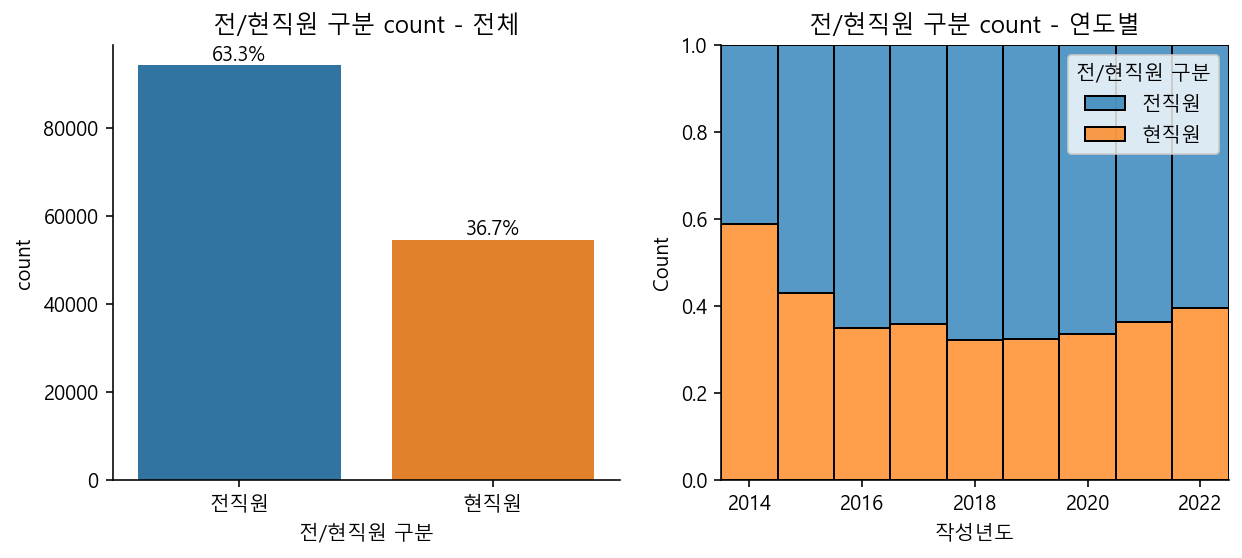

In [68]:
countplot('전/현직원 구분')

- histplot
    - 전직원의 점수분포가 현직원보다 낮다.
    - 기업리뷰 사이트 이용자?
        1. 취업준비 
            - 학생(무료이용 가능) or 유료플랜 이용자 -> 리뷰 데이터 x
        2. 퇴사 후 이직준비(전직원) or 재직 중 이직준비 (현직원)
            - 리뷰데이터 작성시 1년간 리뷰데이터 확인가능
        3. 재직 중 (현직원)
            - 순수하게 다른 회사의 리뷰데이터를 보고 싶어서
    - 사이트 특성상 회사에 만족하며 다니는 사람이 리뷰를 작성하기 보다는, 불만이 있는 경우가 많지 않을까?

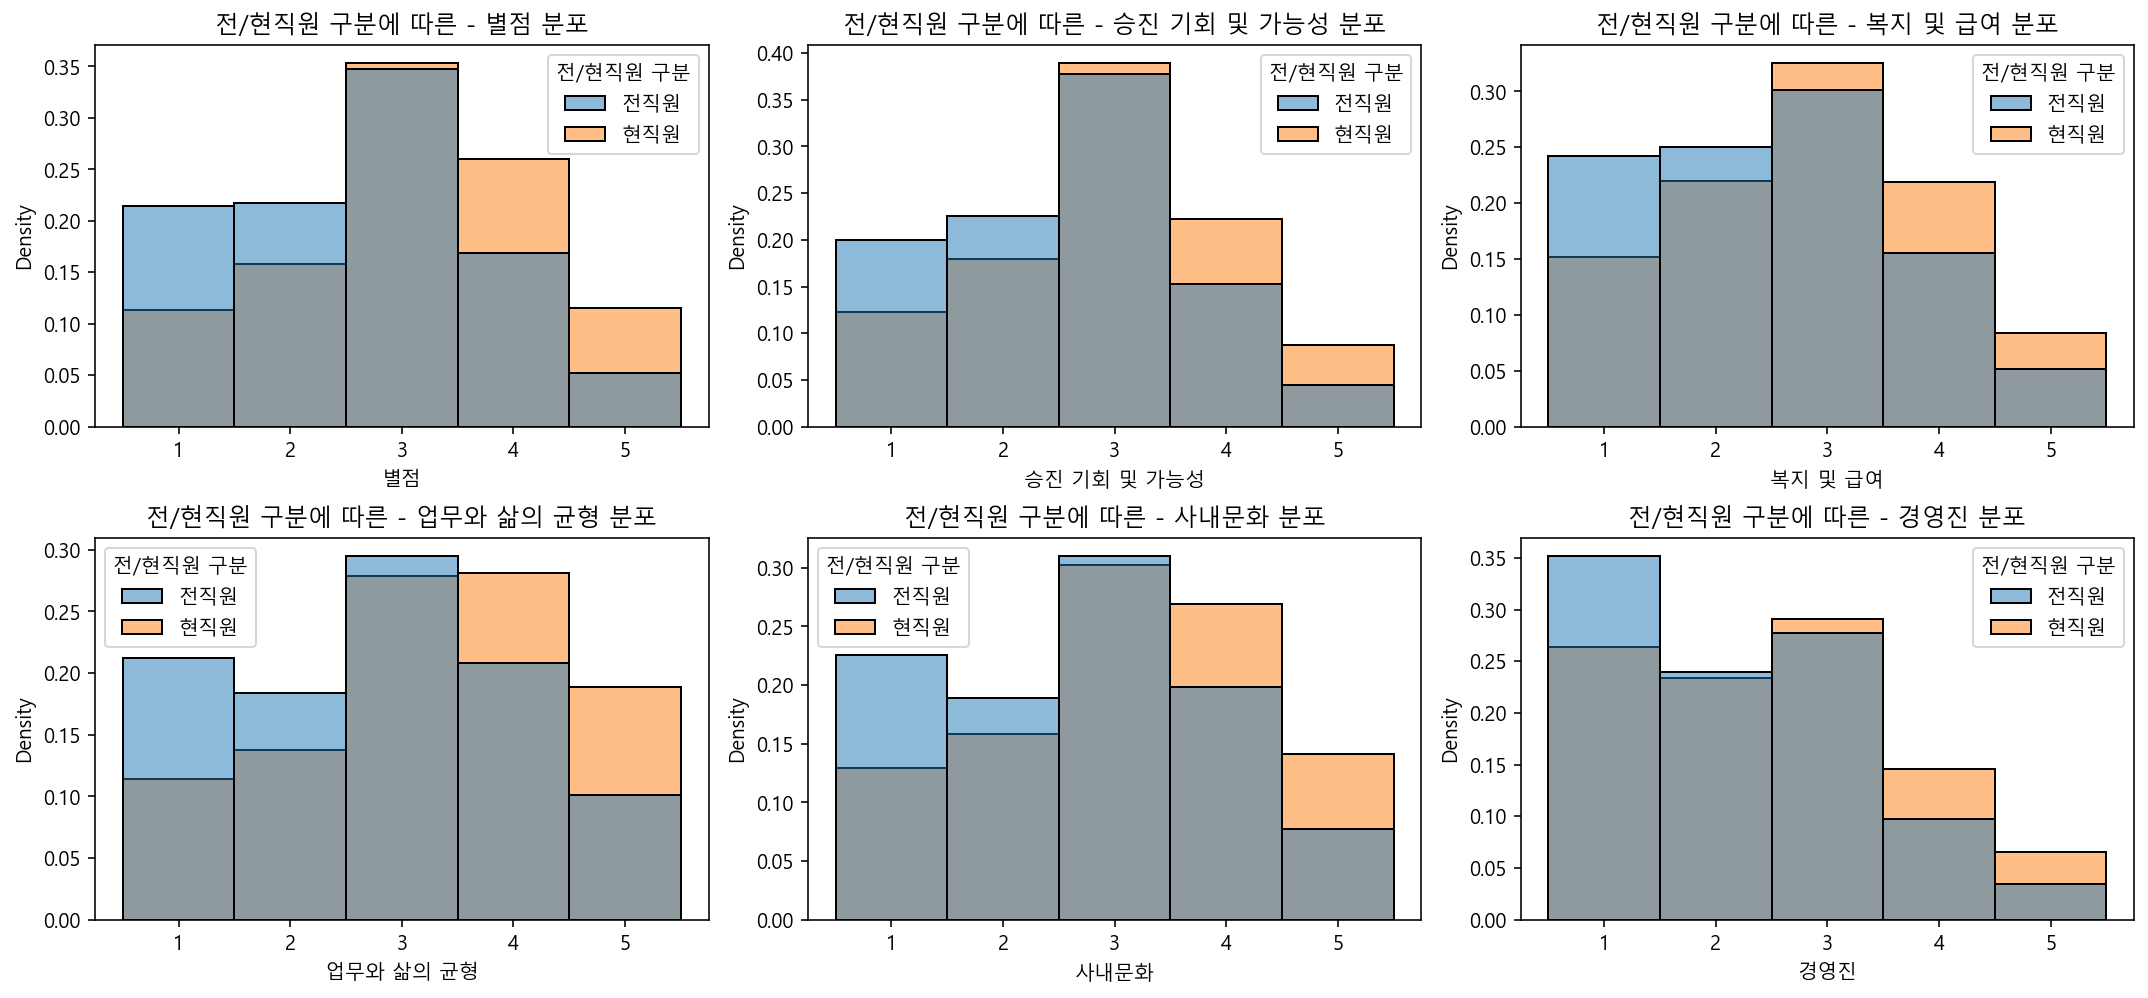

In [69]:
histplot('전/현직원 구분')

- point plot
    - 모든 점수에서 전직원의 평균평점이 상대적(현직원대비)으로 낮다.
    - 두 그룹간 점수차이가 크다

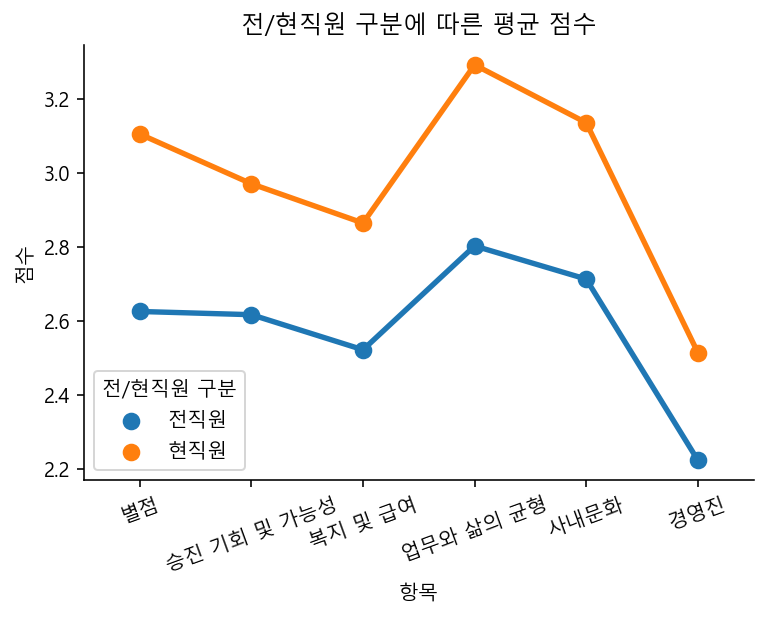

In [70]:
pointplot('전/현직원 구분')

- radarplot

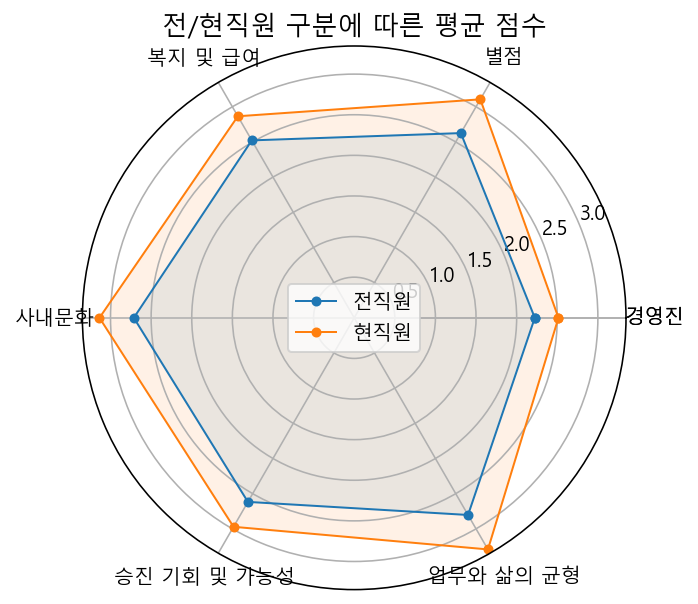

In [71]:
radarplot('전/현직원 구분')

- 비 모수적 검정

In [72]:
mwutest('전/현직원 구분', '전직원', 'less')

별점
H1 채택 - 전직원 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=1980470560.0, pvalue=0.0)
승진 기회 및 가능성
H1 채택 - 전직원 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2118413554.0, pvalue=0.0)
복지 및 급여
H1 채택 - 전직원 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2148098208.5, pvalue=0.0)
업무와 삶의 균형
H1 채택 - 전직원 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2013629556.5, pvalue=0.0)
사내문화
H1 채택 - 전직원 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2079326848.5, pvalue=0.0)
경영진
H1 채택 - 전직원 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=2222979617.0, pvalue=0.0)


- 전현직에 따른 텍스트 데이터 분석

### `근무지역`

- 가설 : 수도권 근무자의 만족도가 높을 것이다. 

In [73]:
# 수도권 여부 컬럼 생성
cond = df['근무지역'].isin(['서울','경기','인천'])
df['수도권여부'] = np.where(cond,'수도권','비수도권')
df.head(1)

회사명   회사코드        직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                      
0      티몬  50695  마케팅/시장조사      전직원   서울  2022   3            5        5   

       업무와 삶의 균형  ...  경영진                         총평  \
index             ...                                   
0              5  ...    5  첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사   

                                     장점  \
index                                     
0      사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함   

                                                     단점  \
index                                                     
0      나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음   

                   경영진에 바라는 점 1년 후 기업 전망 기업 추천여부 게시글 추천 수  IT여부 수도권여부  
index                                                                  
0      좋은 사내문화가 만들어지면 좋을 것 같음         성장      추천        0   비IT   수도권  

[1 rows x 21 columns]

- count plot
    - IT기업 카테고리라서 그런지 대부분(91.4%)의 기업이 수도권에 위치

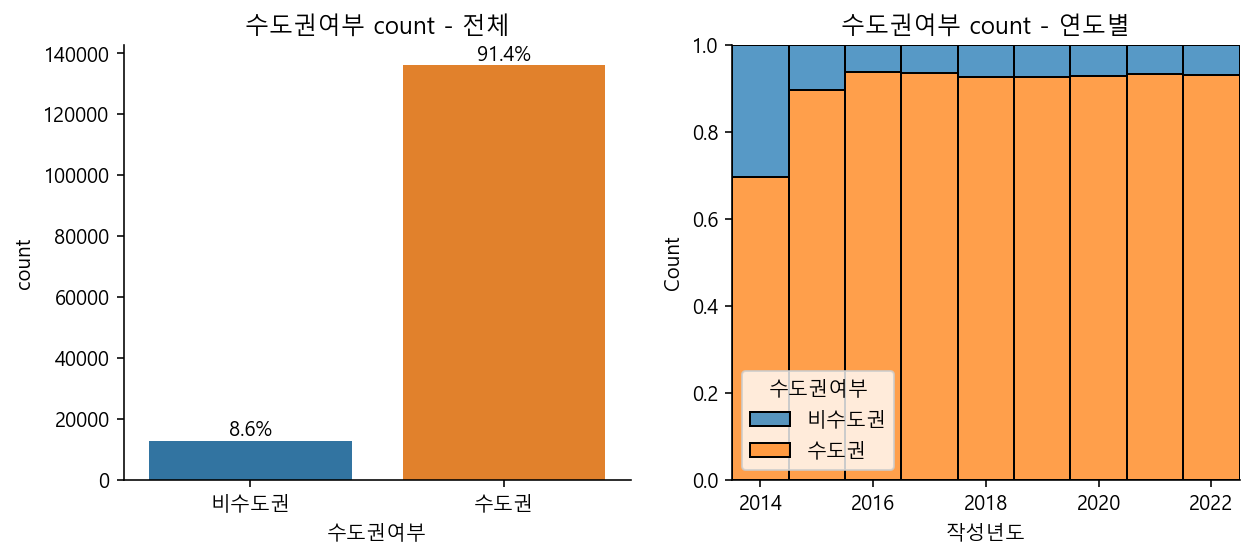

In [74]:
countplot('수도권여부')

- histplot
    - 눈에 띄는 차이 관측 어렵다. 

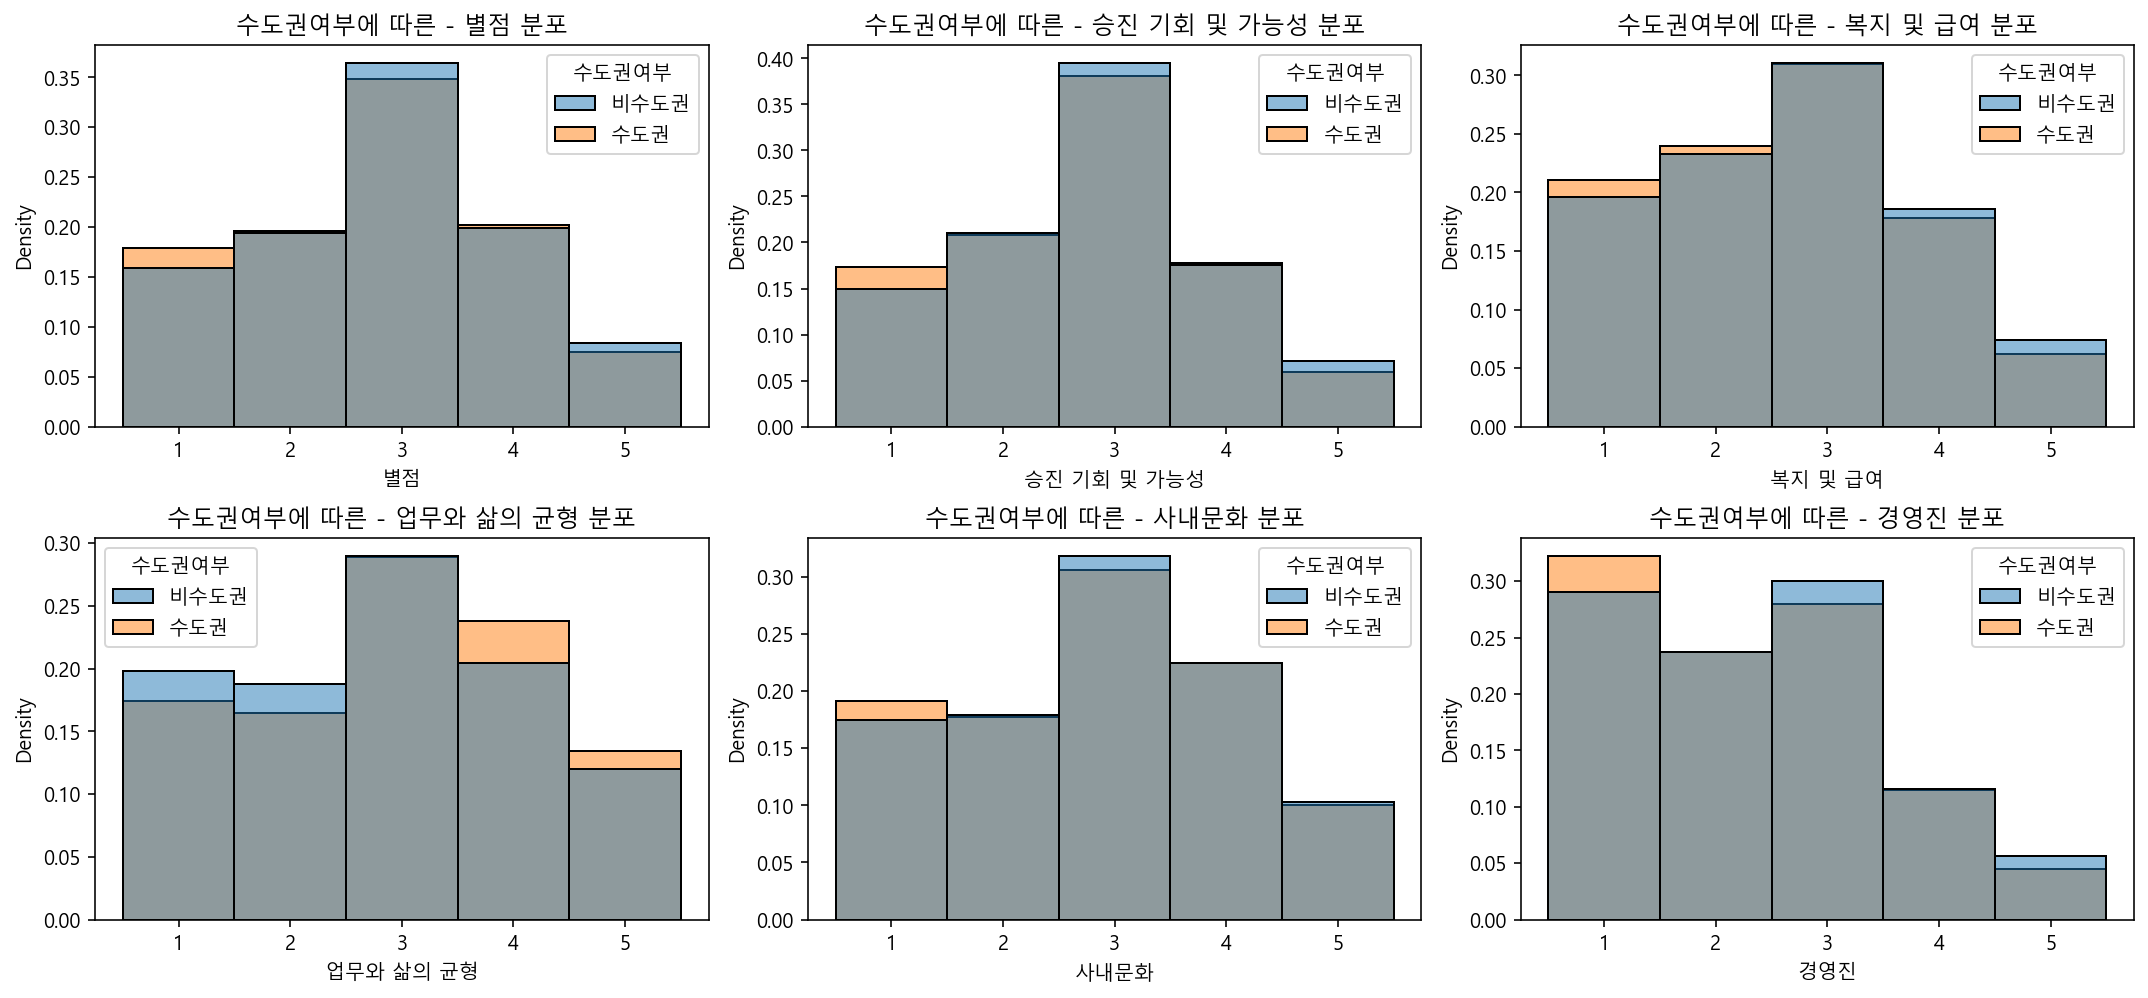

In [75]:
histplot('수도권여부')

- point plot
    - 수도권의 워라밸 말고는 비수도권 대비 점수가 낮다
    - 비수도권의 점수가 왜 오히려 높을까?

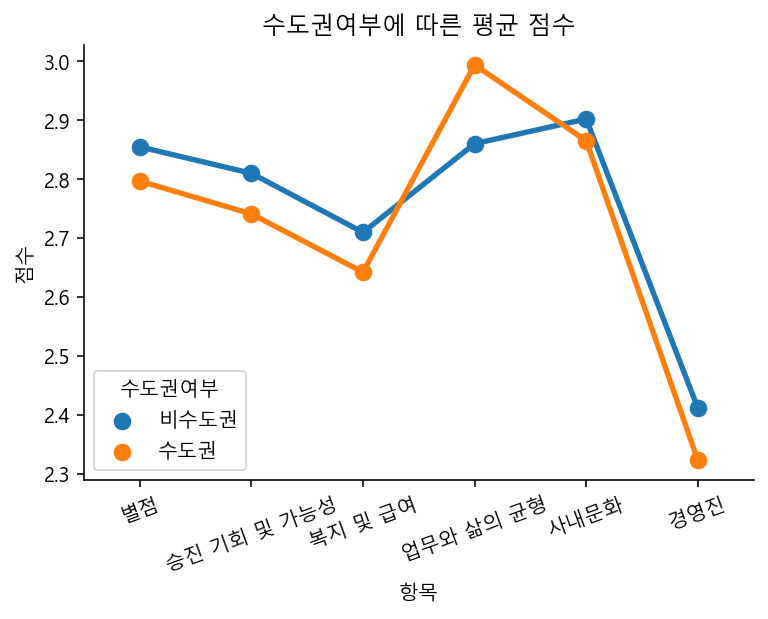

In [76]:
pointplot('수도권여부')

- radar plot
    - 업무와 삶의 균형 외에는 큰 차이 안보인다.

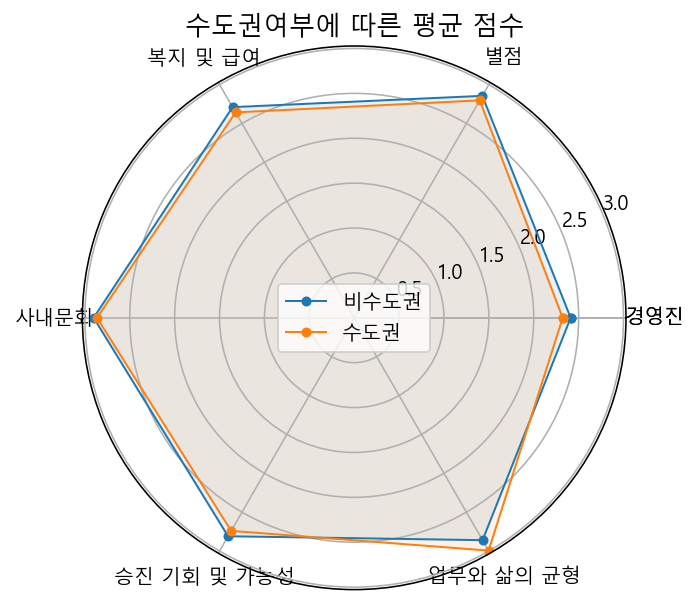

In [77]:
radarplot('수도권여부')

In [78]:
mwutest('수도권여부','수도권')

별점
H0 채택 - 수도권 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=846782853.0, pvalue=0.9999997010645405)
승진 기회 및 가능성
H0 채택 - 수도권 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=842207988.5, pvalue=0.9999999992661068)
복지 및 급여
H0 채택 - 수도권 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=842506526.0, pvalue=0.9999999984482779)
업무와 삶의 균형
H1 채택 - 수도권 그룹의 평점이 더 높다.
MannwhitneyuResult(statistic=921592505.5, pvalue=2.5229559584851237e-31)
사내문화
H0 채택 - 수도권 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=855581140.0, pvalue=0.998713518247846)
경영진
H0 채택 - 수도권 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=833105861.0, pvalue=0.9999999999999997)


- 본사 근무여부
    - 가설 : 본사근무자의 점수가 지사근무자의 점수보다 더 높을 것이다. 

- 수도권 근무여부 컬럼 생성

In [79]:
tmp = df.merge(df_company_list, how='inner', on='회사코드')

df['본사근무여부'] = np.where(tmp['근무지역']==tmp['본사위치'], '본사근무' , '지사근무 or 미응답')
df.head(3)

회사명   회사코드        직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                      
0      티몬  50695  마케팅/시장조사      전직원   서울  2022   3            5        5   
1      티몬  50695     영업/제휴      현직원   서울  2022   3            5        5   
2      티몬  50695       디자인      현직원   서울  2022   2            1        1   

       업무와 삶의 균형  ...                                                 총평  \
index             ...                                                      
0              5  ...                          첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사   
1              5  ...  영업부서는 그나마 운영이 잘되나,  별 의미없는 콘텐츠 제작관련한 리소스가 너무 들...   
2              2  ...              하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진   

                                                      장점  \
index                                                      
0                       사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함   
1      연차사용 자유 / 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화. \n영...   
2      리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...   

                                                      단점  \
index                                                      
0       나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음   
1      동기부여도지 않는 모든것 ? / 2~3년 다니고 경험쌓기는 좋음 MD권한 많음\n대...   
2      있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...   

                                              경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  \
index                                                                         
0                                 좋은 사내문화가 만들어지면 좋을 것 같음         성장      추천   
1      신규사업을 하려면 청사진부터 그리고 방향성에 맞게 가이드라인을 만들고, 인사팀의 권...         비슷      추천   
2      사업에 대한 비전과 그를 실현시킬 수 있는 구체적인 방향을 제시해주길 원합니다모두가...    unknown     비추천   

      게시글 추천 수 IT여부  수도권여부 본사근무여부  
index                              
0            0  비IT    수도권   본사근무  
1            0  비IT    수도권   본사근무  
2            0  비IT    수도권   본사근무  

[3 rows x 22 columns]

- 본사근무(81.4%) - 수도권 근무자(91.4%) 대비 낮은 비율

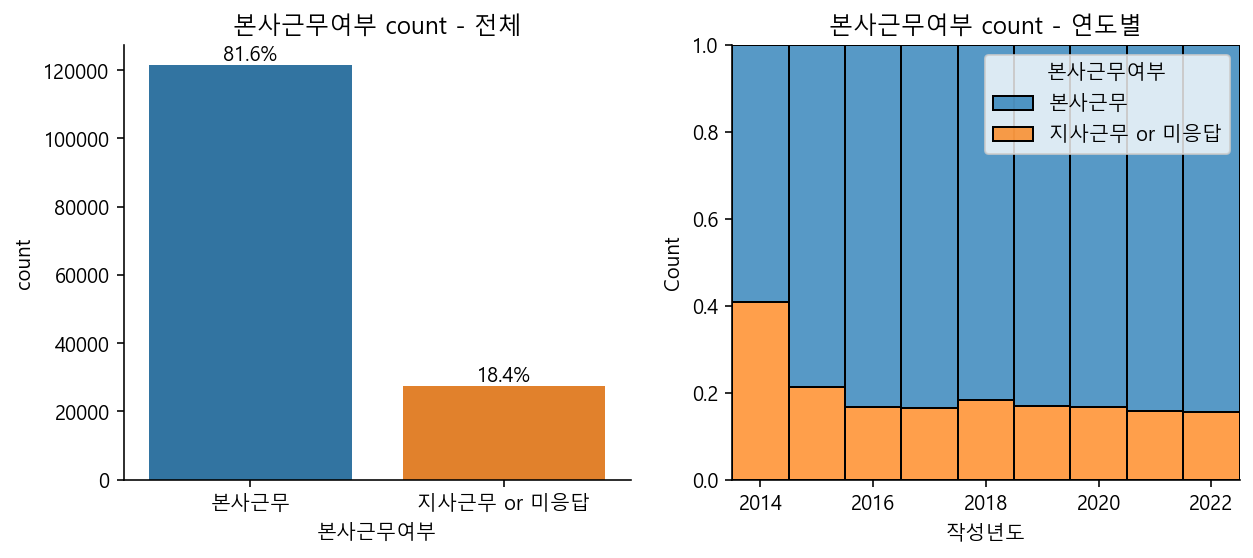

In [80]:
countplot('본사근무여부')

- histplot
    - 본사 근무자의 낮은점수(1,2점) 비율이 지사근무자에 비해 높아보인다. 

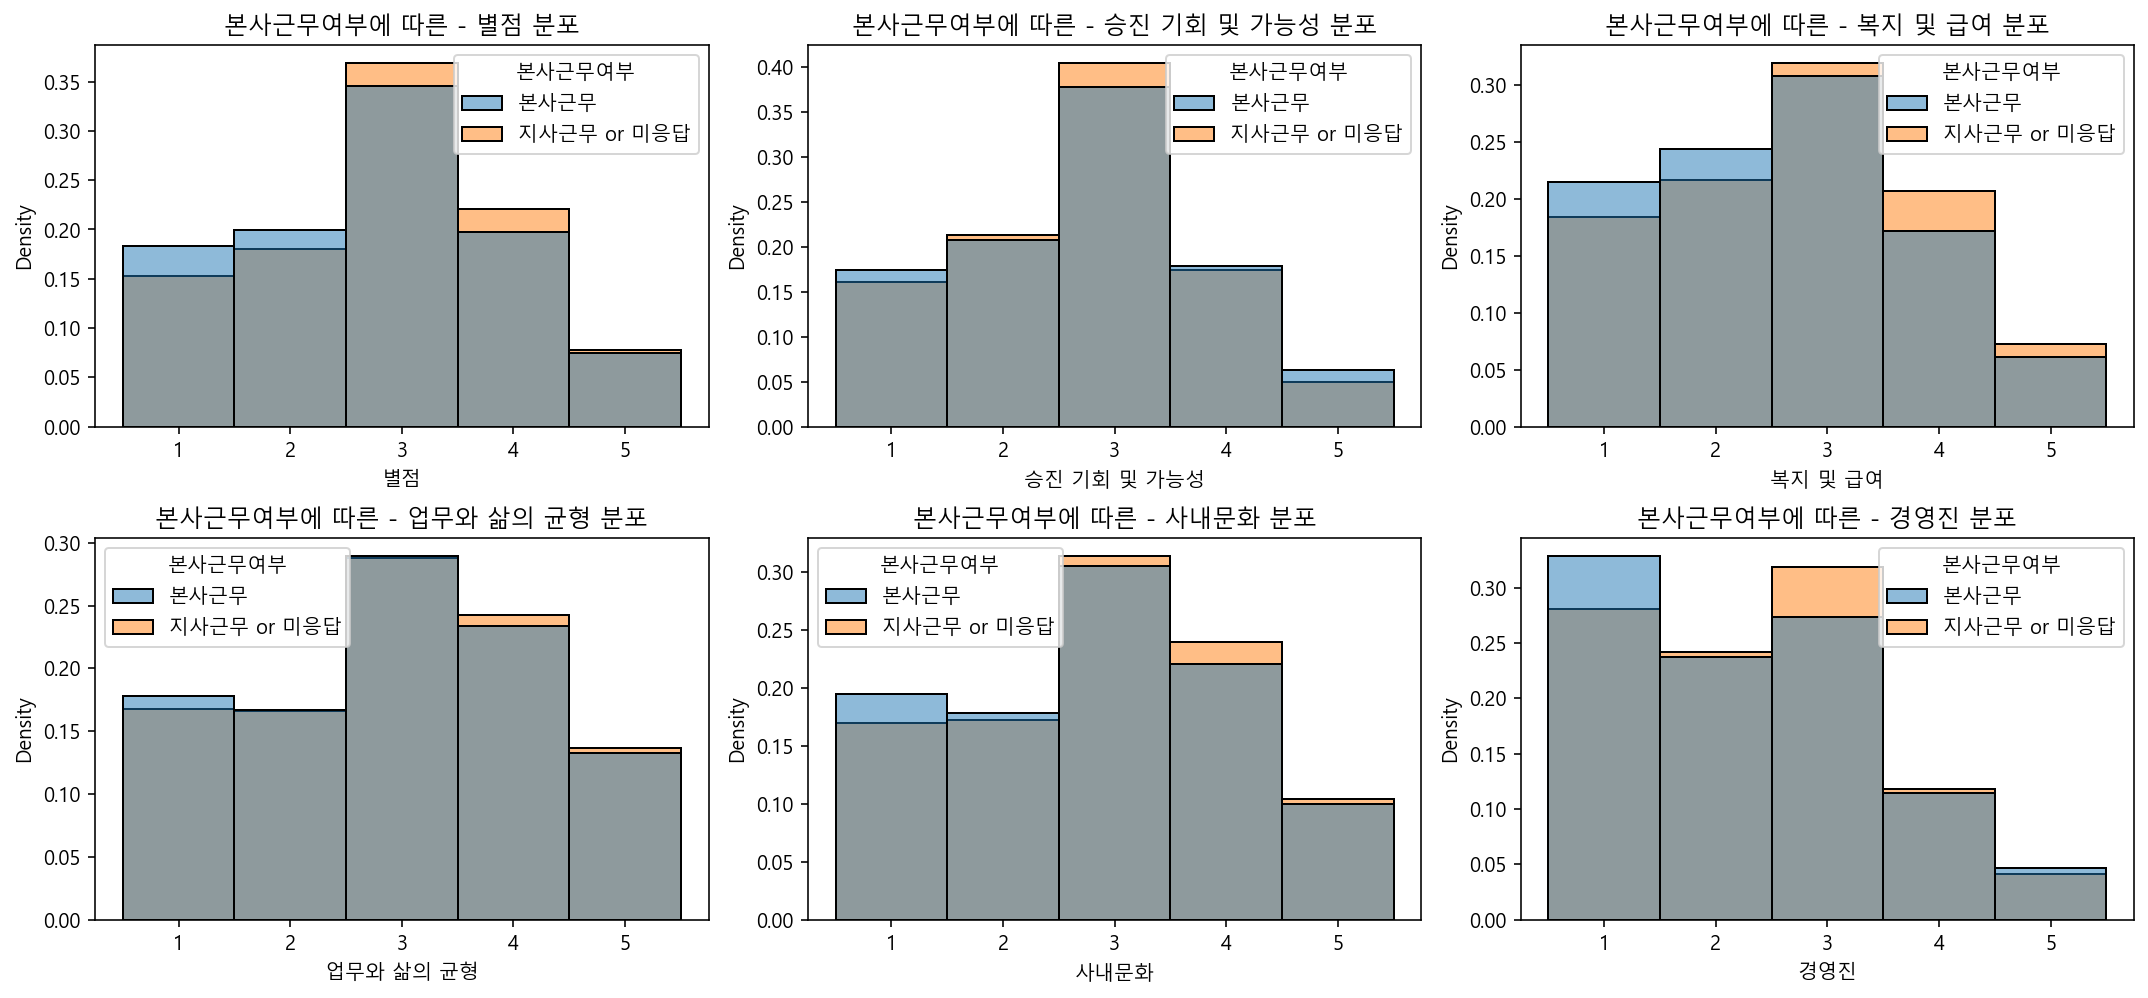

In [81]:
histplot('본사근무여부')

- point plot
    - 지사 근무자의 점수가 오히려 높다. (승진기회 제외)

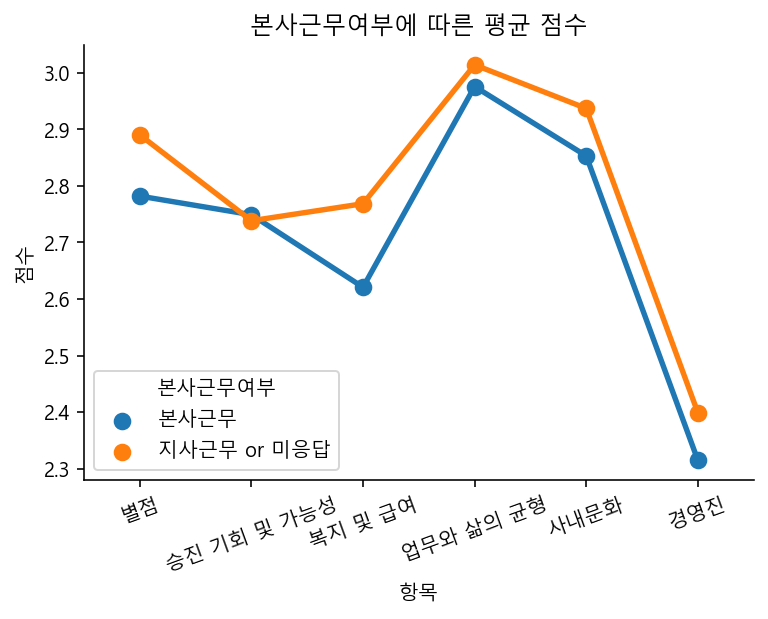

In [82]:
pointplot('본사근무여부')

- radar plot
    - 지사 근무자의 평균점수가 왜 더 높을까

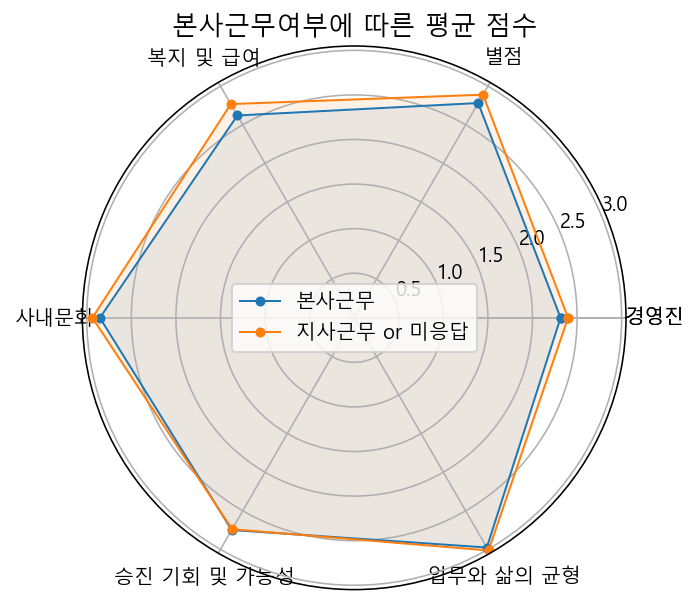

In [83]:
radarplot('본사근무여부')

- 비 모수적 검정

In [84]:
mwutest('본사근무여부','본사근무','greater')

별점
H0 채택 - 본사근무 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=1569875549.5, pvalue=1.0)
승진 기회 및 가능성
H0 기각실패 - 본사근무 그룹의 평점이 더 높다고 보기 어렵다.
MannwhitneyuResult(statistic=1664317011.5, pvalue=0.15657278226094484)
복지 및 급여
H0 채택 - 본사근무 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=1539600393.5, pvalue=1.0)
업무와 삶의 균형
H0 채택 - 본사근무 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=1630175153.5, pvalue=0.9999960736058551)
사내문화
H0 채택 - 본사근무 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=1594873240.5, pvalue=1.0)
경영진
H0 채택 - 본사근무 그룹의 평점이 더 낮다.
MannwhitneyuResult(statistic=1579258464.5, pvalue=1.0)


### `작성월` -> `작성년도`

In [85]:
# 결측치 처리
cond = df['작성년도'] == 'unknown'
df = df[~cond]

- count plot
    - 2017년 기점으로 게시글 수가 폭증한 이유? 
    - 2020년 이후로는 코로나로 인해 IT기업이 힘을 받으면서 커졌을거라 생각
    - 2022년은 4월까지의 데이터라 적음

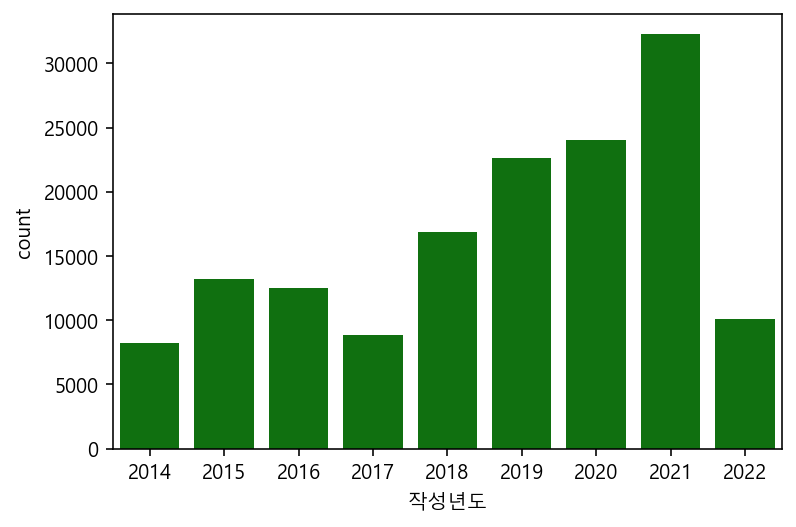

In [86]:
sns.countplot(x='작성년도', data=tmp,order=sorted(df['작성년도'].unique()), color='g');

- 연도별 점수변화

In [87]:
# 연도별 테이블 생성 
grouped = df[['작성년도'] + arr_scores].groupby('작성년도').mean()
# grouped = grouped.drop('unknown', axis=0)
grouped.T.style.background_gradient(cmap='Blues',axis=0)

- 2017년도에 무슨일이? 
    - 2017년에 모든항목 평점 최저치 
- 업무와 삶의 균형 -> 2018년부터 매우 높아짐
- 경영진에 대한 불만이 가장 심한가?
    - 경영진 점수가 다른 점수들에 비해 유난히 낮다. 

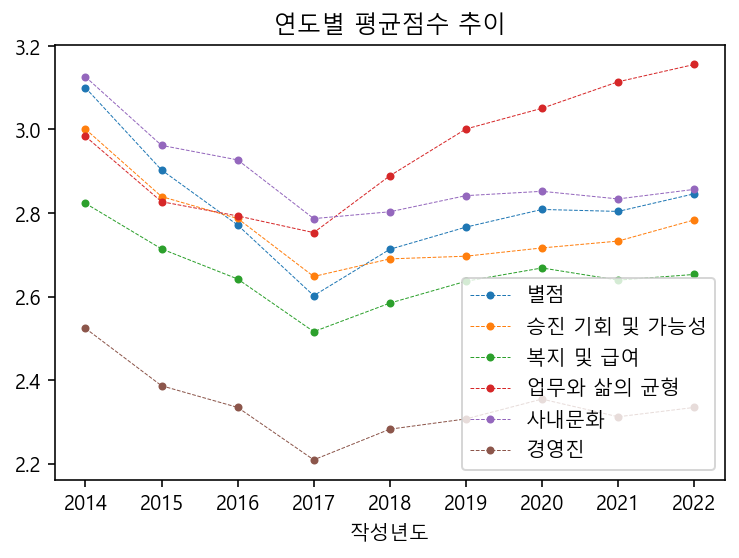

In [88]:
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--')
plt.title('연도별 평균점수 추이')
plt.show()

- IT vs 비 IT도 같은 경향인지 확인

In [89]:
cond = df['IT여부'] == 'IT'
df_it = df[cond]
df_nit = df[~cond]

In [90]:
# it
grouped = df_it[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T.style.background_gradient(cmap='Blues',axis=0)

In [91]:
# 비 it
grouped = df_nit[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T.style.background_gradient(cmap='Blues',axis=0)

- 전반적인 추제는 비슷한데
    - 비 IT직군의 경우 2017년에 최저치 이후 모든항목의 평점이 시간이 지날수록 꾸준하게 상승하고 있는 반면, 
    - IT직군의 경우 업무와 삶의 균형(워라밸), 승진기회 및 가능성 외에는 2020~2021년 기점으로 다시 하락세를 보인다. 

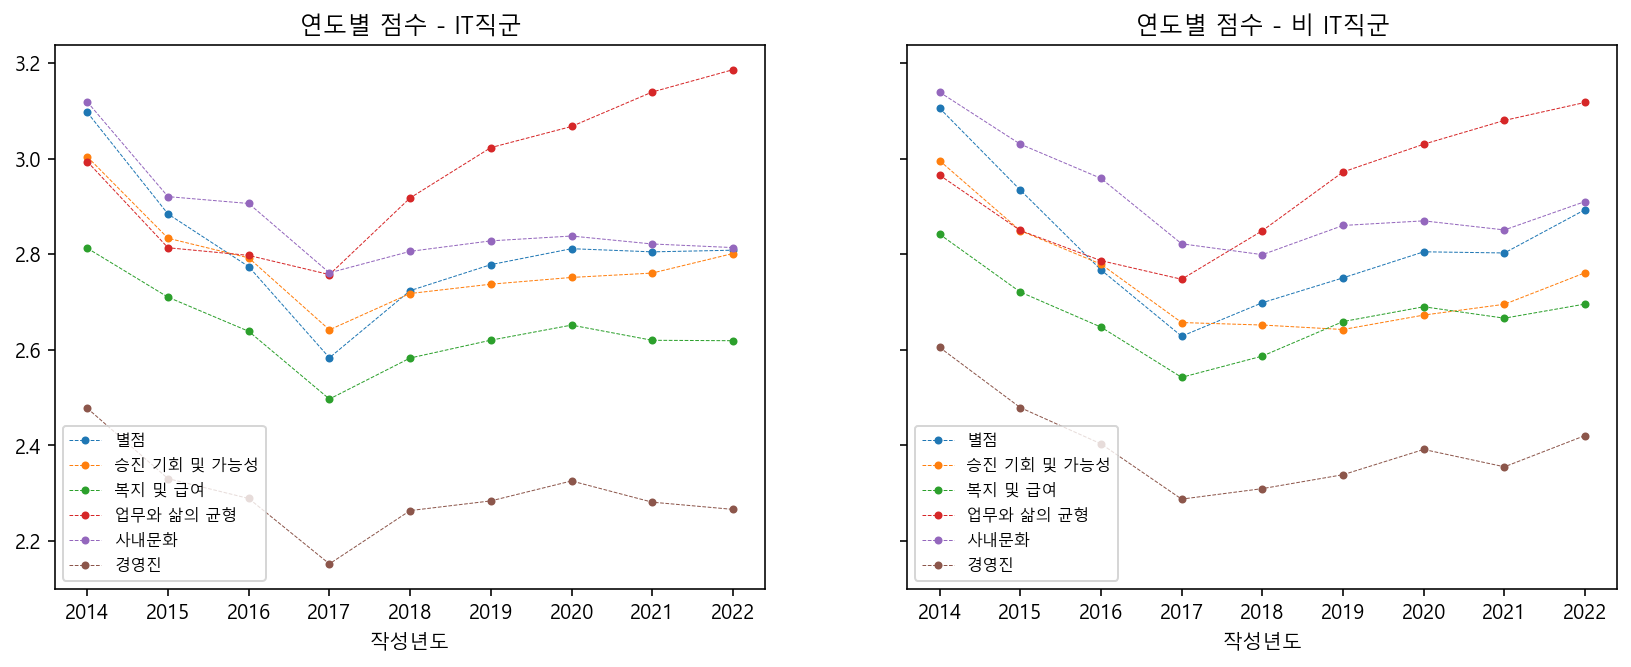

In [92]:
#시각화
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)

#it
grouped = df_it[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--', ax=ax[0])
ax[0].set_title('연도별 점수 - IT직군')
ax[0].legend(fontsize=8)

#non-it
grouped = df_nit[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--', ax=ax[1])
ax[1].set_title('연도별 점수 - 비 IT직군')
ax[1].legend(fontsize=8)

plt.show()

### `1년 후 기업 전망`
- 성장 / 비슷 2가지 선택지 + 미응답
- 전체의 20.7%만이 1년뒤에 기업이 성장할 것이라고 작성   

In [93]:
df['1년 후 기업 전망'].unique()

array(['성장', '비슷', 'unknown'], dtype=object)

In [94]:
# 결측치 항목명 변경
df['1년 후 기업 전망'] = np.where(df['1년 후 기업 전망']=='unknown', '미응답', df['1년 후 기업 전망'])
df['1년 후 기업 전망'].unique()

array(['성장', '비슷', '미응답'], dtype=object)

- countplot
    - 1년 후에도 현재랑 비슷할 것이라고 응답한 비율이 전체의 49.7%로 가장 많다.
    - 성장 할것이라고 응답한 경우가 시간이 지날 수록 줄어드는 추세 보임 

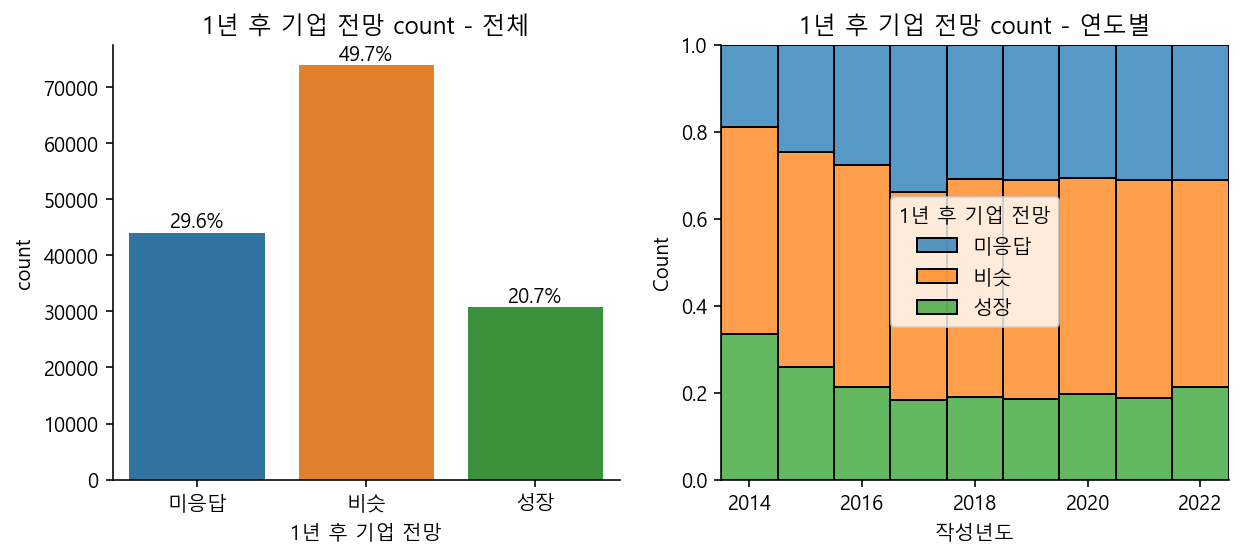

In [95]:
countplot('1년 후 기업 전망')

- 1년 후 기업이 성장 할 것이다 라고 예상한 경우의 만족도가 그렇지 않은 그룹에 비해 만족도가 높다. 

- 미응답의 경우가 점수가 제일 낮음
    - 성장 > 비슷 > 미응답

In [96]:
grouped = df[['1년 후 기업 전망'] + arr_scores].groupby('1년 후 기업 전망').mean()
grouped.style.background_gradient(cmap='Blues')

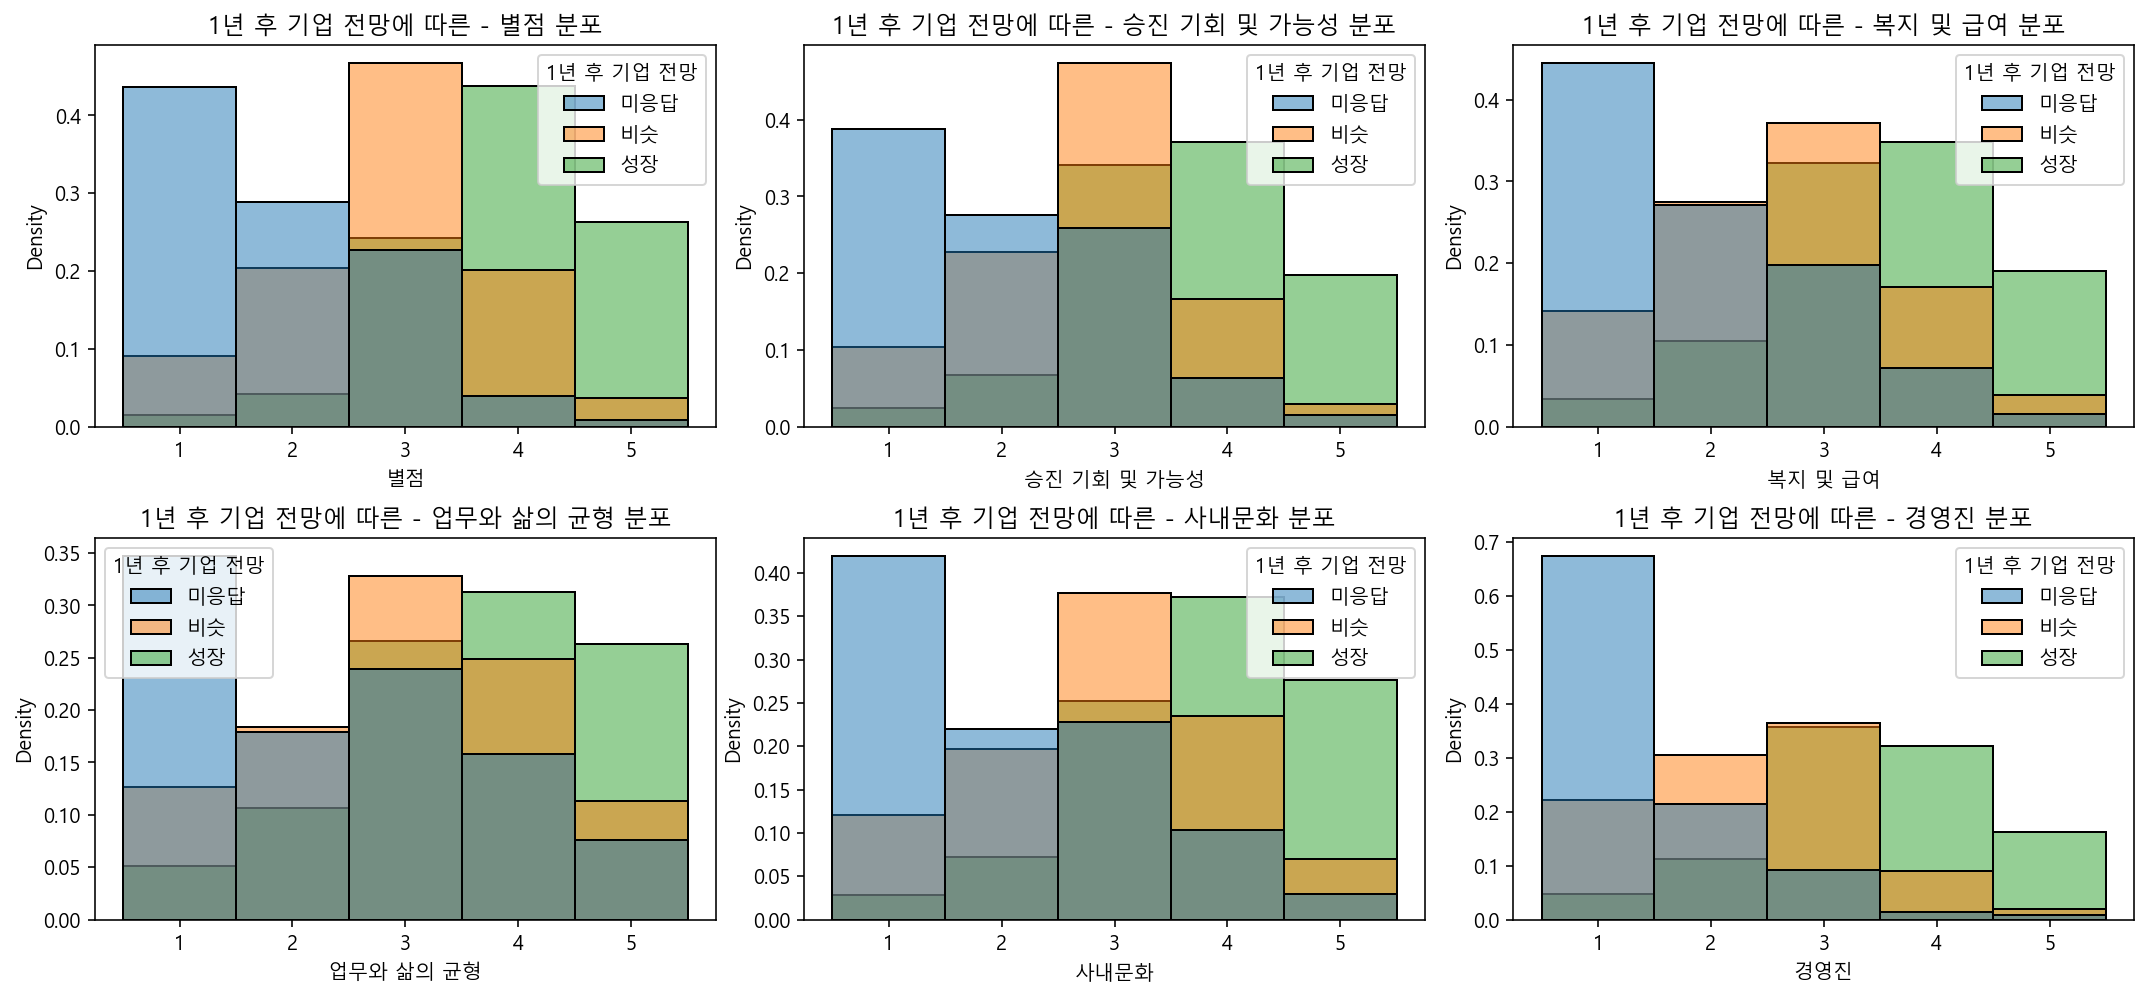

In [97]:
histplot('1년 후 기업 전망')

- point plot
    - 그룹 간 점수차이가 명확하게 보인다. 

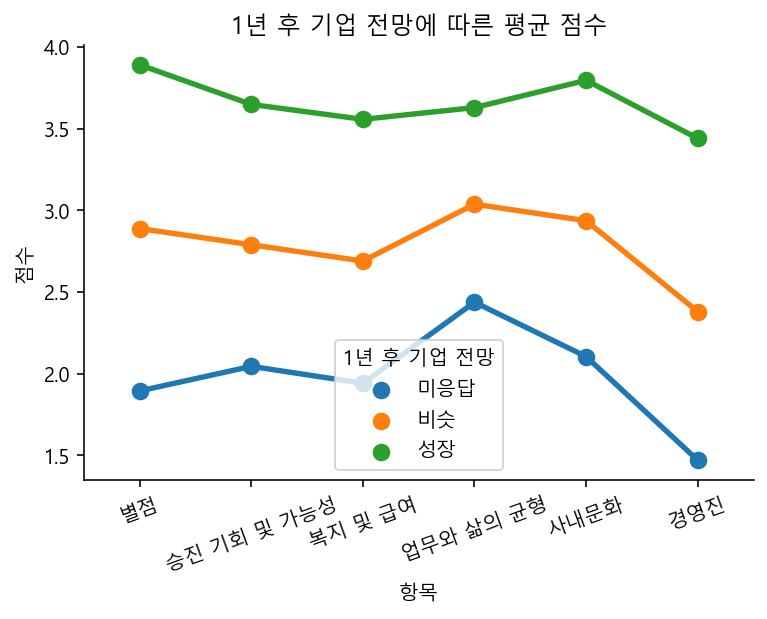

In [98]:
pointplot('1년 후 기업 전망')

- radar plot

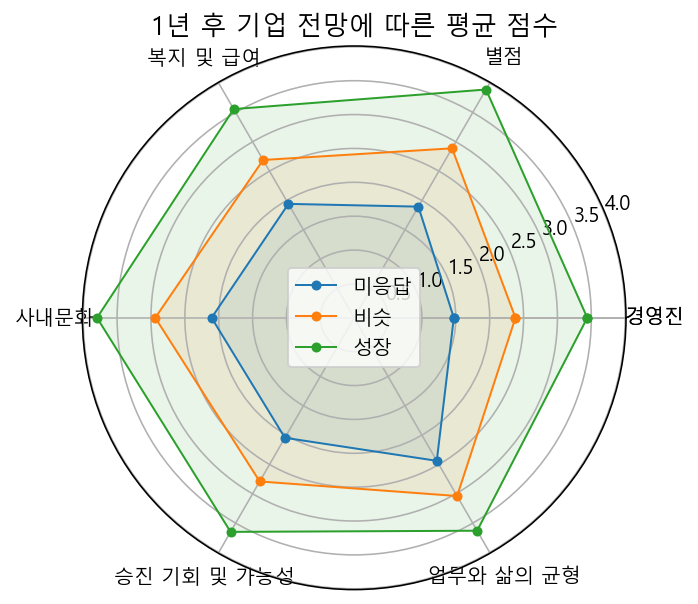

In [99]:
radarplot('1년 후 기업 전망')

###  `기업 추천여부`
- 1년 후 기업 전망과 기업 추천여부는 매우 비슷한 항목인 것 같은데?
    - 기업을 추천한 경우가 전체의 49.2%로, 1년 후 기업이 성장할 것이다라고 응답한 경우보다 높은 비율을 보인다.
    - 1년 뒤에도 기업이 비슷할 것 같은데 추천한 경우가 상당 수 있다. 
        -> 어떤 경우?

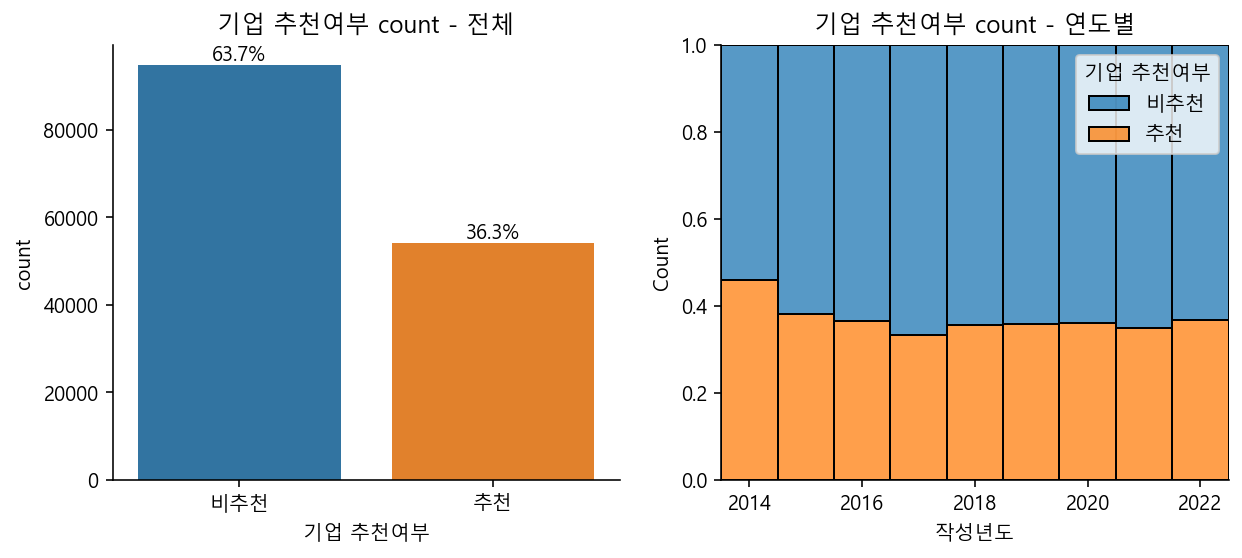

In [100]:
countplot('기업 추천여부')

- point plot
    - 그룹간 점수차이 명확

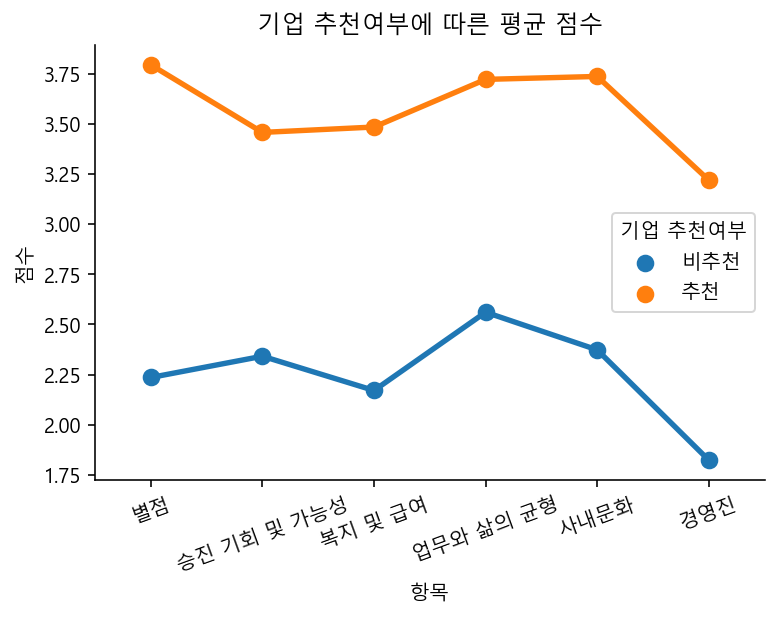

In [101]:
pointplot('기업 추천여부')

- radar plot

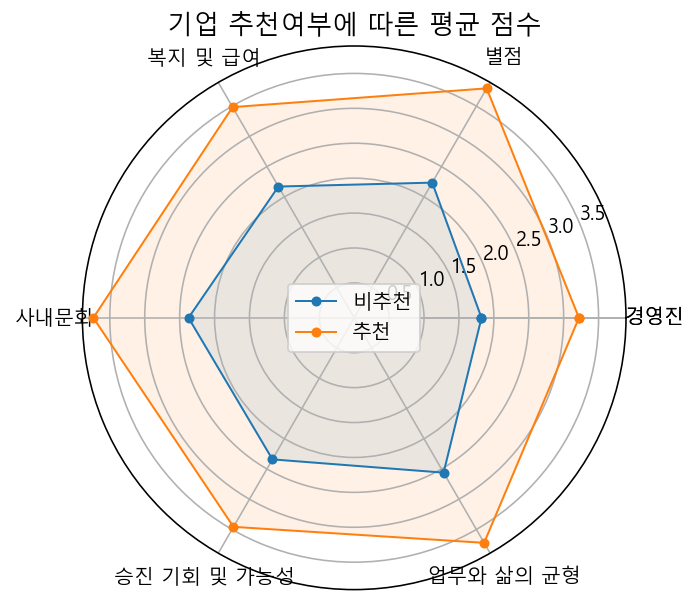

In [102]:
radarplot('기업 추천여부')

- 기업 비추천한 경우 
    - 1년 후 기업전망을 긍정적으로 보는 경우는 매우 적다(약 3.6%). 
    - 비슷 or 미응답 에 전체의 60% 차지
- 기업을 추천한 경우 
    - 미응답이 1.8%로 매우 적다.
    - 비슷하거나 성장할것이라고 대부분 응답

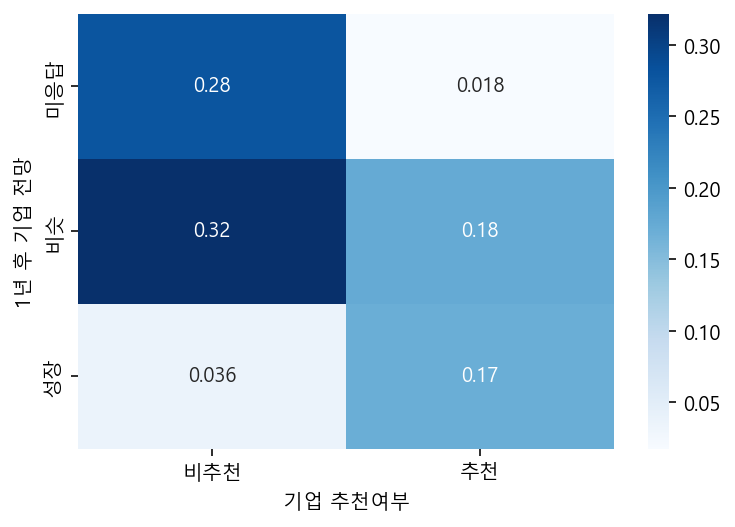

In [103]:
grouped = df[['1년 후 기업 전망', '기업 추천여부']].value_counts(['1년 후 기업 전망','기업 추천여부'])
grouped_ct = pd.crosstab(df['1년 후 기업 전망'], df['기업 추천여부'], normalize=True)
sns.heatmap(grouped_ct, annot=True, cmap='Blues');

### `게시글 추천 수`

- describe

In [104]:
df['게시글 추천 수'].describe()

count    148659.000000
mean          1.651377
std           4.172596
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         624.000000
Name: 게시글 추천 수, dtype: float64

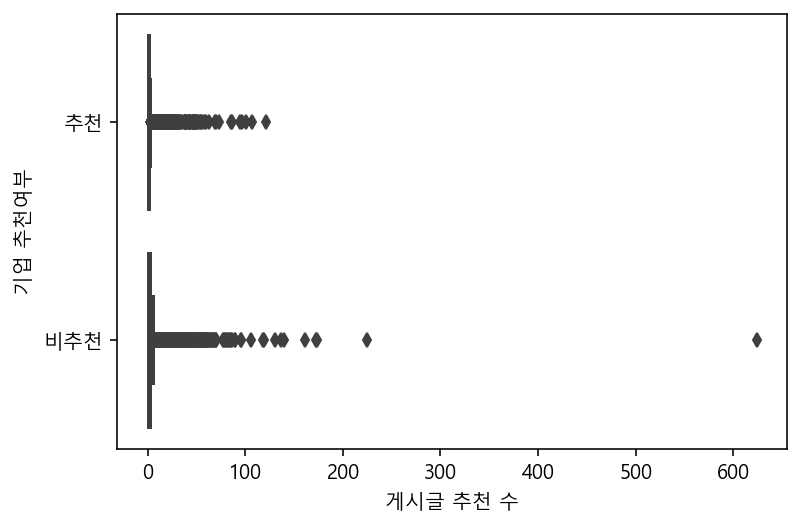

In [105]:
x='게시글 추천 수'
sns.boxplot(x=x, data=df, y='기업 추천여부');

- 추천수 80개 이상 - 기업 추천
    - 유명한 기업의 게시글

In [106]:
cond1 = df['게시글 추천 수'] > 80
cond2 = df['기업 추천여부'] == '추천'
df[cond1 & cond2]

회사명    회사코드        직군 전/현직원 구분     근무지역  작성년도  별점  승진 기회 및 가능성  \
index                                                                        
71293   비바리퍼블리카  309507    IT/인터넷      전직원       서울  2018   4            4   
77306     구글코리아   44566    IT/인터넷      전직원       서울  2015   4            3   
77317     구글코리아   44566  서비스/고객지원      전직원       서울  2015   4            3   
100487  아마존웹서비스   89330    IT/인터넷      전직원  unknown  2014   4            2   
102726     잡플래닛   86783    IT/인터넷      전직원       서울  2019   3            1   
102742     잡플래닛   86783    미디어/홍보      현직원       서울  2015   5            5   
121517  페이스북코리아   90364     영업/제휴      현직원  unknown  2015   5            5   

        복지 및 급여  업무와 삶의 균형  ...  \
index                       ...   
71293         4          2  ...   
77306         4          5  ...   
77317         4          4  ...   
100487        1          3  ...   
102726        2          5  ...   
102742        4          5  ...   
121517        5          4  ...   

                                                       총평  \
index                                                       
71293     언제까지 대표님의 운으로 갈 수 있을지 모르겠어요. 최종적으로 꿈꾸는건 은행일려나요?   
77306   열린 기업 및 복지 문화를 가진 글로벌 회사로서 한국 기업에게 본이 되는 회사로 전...   
77317   구글이 어떻게 돈을 버는 회사인지 반드시 알아보세요. 많은 분들이 신문이나 잡지에서...   
100487  첫 직장으로는 추천하지 않습니다.  경력직도 대기업 대상 영업직이라면 추천 드리지 ...   
102726  철저한 계급사회 - 양반이 아니라면 발전은 힘들것 - 조선시대와 흡사2가지 계급이 ...   
102742  글로벌 서비스로 성장하는 스타트업인데 펀딩도 넉넉히 받음. 한국을 비롯해 전 세계 ...   
121517       세상을 연결한다는 자부심, 가장 빠르게 성장하는 글로벌 기업, 자율적인 기업문화   

                                                       장점  \
index                                                       
71293   식대의 리밋이 없다는 점, 눈치 안보고 밥 먹을 수 있다는 점. 연차휴가를 자유롭게...   
77306   1. 돈이 아닌 삶을 윤택하게 하는 가치를 중심으로 회사 업무가 정해지는 회사 시스...   
77317   외국계 기업치고 다 한국화되어버려서 제대로 된 외국계가 별로 없는데, 구글 코리아는...   
100487  아마존의 기술력을 바탕으로 한 제품은 뛰어 납니다.  그리고 내가 원하는 이상으로 ...   
102726                  정말 자유로운 연차사용재택근무탄력근무(9시 또는 10시출근)   
102742  "서비스 시작 1년 밖에 안 된 스타트업인데 월 방문자가 300만명이 넘었다." \...   
121517  직원 개개인에 대한 신뢰를 바탕으로 자율적인 문화로 운영되는 회사. 사람을 가장 중...   

                                                       단점  \
index                                                       
71293   정부가 IT업계의 포괄임금제를 끝장내려고 한다면 가장 먼저 제보 할 회사. 역삼역 ...   
77306   단점이라고 하기엔 그렇지만 꼭 적어야 하는 것 같아서 아래와 같이 남깁니다. \n1...   
77317   대학 졸업하신 사회초년생 분들께는 많이 힘들 수 있습니다. 좋은 대학 나온 사람들이...   
100487  기업이 제공하는 benefit에 대해 확실히 확인 하세요.  핸드폰 비용에 대한 한...   
102726  너무 업무변경 잦으며 정확한 목표가 없음변화하기 힘듦회사일을 통한 자기 발전은 어려...   
102742  아직 매출이 없다. 비즈니스 모델을 만들어가고 있는 과정이라 언제 매출이 날지 몰라...   
121517  빠른속도로 움직이는 회사이다보니 하루가 다르게 플랫폼, 제품, 정책들이 변함. 안정...   

                                               경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  \
index                                                                          
71293   요새 이승건 대표님. 마케팅부서나 고객행복팀 부서 옆에 앉아서 그냥 일한다고 하지만...         성장      추천   
77306   1. 한국에 좋은 기업 문화를 소개해 줘서 감사드리고, 이런 기업 문화가 타 기업에...         성장      추천   
77317   전세계를 호령하는 구글이 한국에서 고전하는데에는 분명 이유가 있을 것입니다. 물론 ...         성장      추천   
100487  이제 주식도 좀 올라가야 하지 않을까요?  미래에 대한 투자는 제품과 기술력도 있겠...         성장      추천   
102726  빠른 실패도 발전의 한 방법임을 깨닮았으면..백정, 양반으로 나누지 말고 모두의 의...         비슷      추천   
102742  결정과 실행이 빠른 건 무척 좋다. 경영진들이 항상 적재 적소에 좋은 판단을 내리는...         성장      추천   
121517         회사와 팀이 커지더라도 지금과 같이 자율적이고 수평적인 문화를 유지해주세요.         성장      추천   

       게시글 추천 수 IT여부  수도권여부       본사근무여부  
index                                     
71293        94   IT    수도권         본사근무  
77306        85   IT    수도권         본사근무  
77317       121  비IT    수도권         본사근무  
100487       86   IT   비수도권  지사근무 or 미응답  
102726      107   IT    수도권         본사근무  
102742       97  비IT    수도권         본사근무  
121517      101  비IT   비수도권  지사근무 or 미응답  

[7 rows x 22 columns]

- 추천수 80개 이상 - 기업 비추천
    - 여기도 유명한 기업의 게시글이 많은데?

In [107]:
cond1 = df['게시글 추천 수'] > 80
cond2 = df['기업 추천여부'] == '비추천'
df[cond1 & cond2]

회사명    회사코드         직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  \
index                                                                       
32275      우아한형제들   61420   서비스/고객지원      전직원   서울  2017   2            3   
32322      우아한형제들   61420     IT/인터넷      현직원   서울  2016   4            4   
35240     마이다스아이티   78090     IT/인터넷      전직원   경기  2018   1            1   
35288     마이다스아이티   78090  경영/기획/컨설팅      전직원   경기  2017   1            3   
71201     비바리퍼블리카  309507  경영/기획/컨설팅      전직원   서울  2021   1            1   
71226     비바리퍼블리카  309507  경영/기획/컨설팅      전직원   서울  2021   1            1   
71240     비바리퍼블리카  309507     IT/인터넷      현직원   서울  2020   1            2   
71245     비바리퍼블리카  309507  경영/기획/컨설팅      전직원   서울  2020   1            2   
71272     비바리퍼블리카  309507   서비스/고객지원      전직원   서울  2020   4            1   
76239   카카오엔터테인먼트   50181     IT/인터넷      전직원   경기  2019   1            1   
102690       잡플래닛   86783     IT/인터넷      전직원   서울  2021   1            3   
103950      뱅크샐러드  276354        디자인      현직원   서울  2020   1            2   
111463     카카오스타일    6881     IT/인터넷      전직원   서울  2020   1            1   
111479     카카오스타일    6881     IT/인터넷      현직원   서울  2019   2            1   
111550        트릿지  322659        디자인      전직원   서울  2020   1            3   
132891  이지원인터넷서비스   58361     IT/인터넷      전직원   서울  2018   1            1   
132892  이지원인터넷서비스   58361     IT/인터넷      전직원   경기  2018   2            4   
132904  이지원인터넷서비스   58361     IT/인터넷      전직원   경기  2016   2            3   
134806    드라마앤컴퍼니   80176     IT/인터넷      현직원   서울  2018   1            3   
135915         왓챠   87452     IT/인터넷      현직원   서울  2020   2            3   
135926         왓챠   87452     IT/인터넷      전직원   서울  2019   3            2   

        복지 및 급여  업무와 삶의 균형  ...  \
index                       ...   
32275         4          1  ...   
32322         3          4  ...   
35240         1          1  ...   
35288         4          1  ...   
71201         4          1  ...   
71226         3          1  ...   
71240         3          1  ...   
71245         2          1  ...   
71272         3          2  ...   
76239         1          1  ...   
102690        3          3  ...   
103950        3          2  ...   
111463        2          1  ...   
111479        2          3  ...   
111550        4          3  ...   
132891        1          1  ...   
132892        1          1  ...   
132904        1          2  ...   
134806        1          1  ...   
135915        2          3  ...   
135926        4          1  ...   

                                                       총평  \
index                                                       
32275   젊고 유쾌하고 자유롭고 수평적이면서도 수직적인 다양한 면모를 가졌지만 일부 운영진이...   
32322          9시 1분은 9시가 아니라서 좀 아쉽지만, 젊고 에너지가 넘치는 활기찬 회사   
35240                              외부 이미지를 위해 총력을 기울이는 회사   
35288                        대외 이미지만 보고 입사한다면 반드시 후회하는 회사   
71201   돈으로 홍보해서 사람을 모으지만 그 사람들 1년내 퇴사 다수입니다. 어떻게 이런 곳...   
71226            연봉 복리후생 조건은 좋으나 그 모든것을 압살하는 안좋은 문화가 있습니다   
71240   이런 기업 리뷰 공간에서조차 억지 평이 잔득 올라오며, 비판 리뷰가 묻히게 만드는 ...   
71245   한 문장으로 요약하자면.... If you join TOSS Team, they w...   
71272   미친듯이 성장에 몰입하는 인재들이 패기넘치는 회사.대표가 내세우는 슬로건과 실제 내...   
76239   이사급으로 가는 거 아니면 절대 가지 말아야 할, 겉으론 성장하는 듯 보이지만 퇴화...   
102690  회사가 크지 않음에도 젊은 또래들한테 이름만 말해도 다 아는 것이 좋았..........   
103950  대표와 경영진의 괴리가 크고, 경영진과 직원의 괴리는 심각하다.(여기 있는 동안의 ...   
111463                            채용공고 관심도 갖지말고 절대 오지 마세요   
111479  대기업보다 고리타분한 정체성 없는 기업. 스타트업의 활력과 열정을 꿈꾸는 도전의식 ...   
111550  대표, 실무자 모두 회사에 대한 자부심과 열정이 있던 회사, 그러나 나에겐 최악의 ...   
132891         전형적인 꼰대마인드의 대표가 있는한 발전은 고사하고 후퇴할수 밖에 없는 기업   
132892                      군대식 꼰대문화의 절정, 출근은 있지만 퇴근은 없다.   
132904  기업문화 자체가 군대식이다. 담배, 술을 권하고 이사나 사장이 사원이나 주임보다 훨...   
134806  5점받을 회사는 아니다. 단점도 있기 마련인데 잡플래닛은 만점만 수두룩한걸 보니 의...   
135915  직원을 키울 능력과 의지는 없으면서 높은 기준을 내세우고, 회사가 팽창하며 시스템의...   
135926        개발자 중심 사내문화, 권력 구조.\n겉보기엔 좋은데 들여다보면 답답한 회사.   

                                

- 부정적인 게시글의 추천수가 더 높다? 
    - 비추천 > 추천
    - 미응답 > 비슷 > 성장
    - 점수는 반대

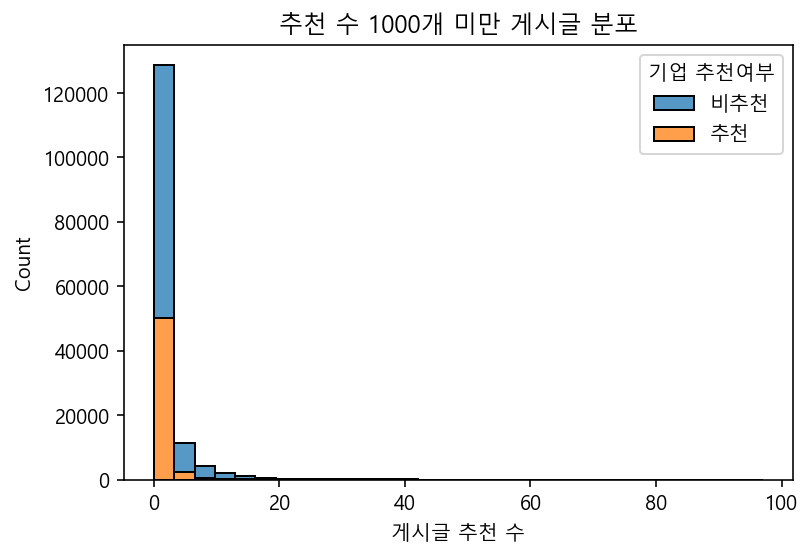

In [108]:
sns.histplot(x='게시글 추천 수', data=df[df['게시글 추천 수']<100], bins=30, hue='기업 추천여부', hue_order=['비추천','추천'],multiple='stack')
plt.title('추천 수 1000개 미만 게시글 분포');

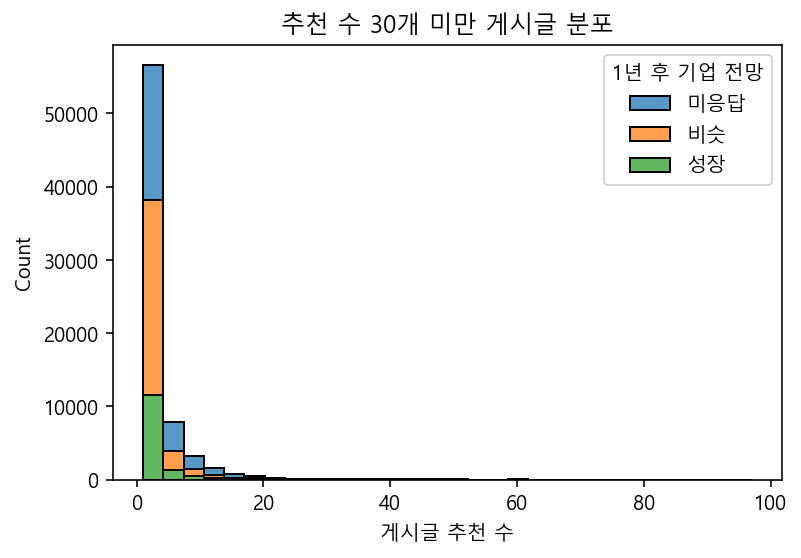

In [109]:
sns.histplot(x='게시글 추천 수', data=df[(df['게시글 추천 수']>0) & (df['게시글 추천 수']<100)], bins=30, hue='1년 후 기업 전망', hue_order=['미응답','비슷','성장'], multiple='stack')
plt.title('추천 수 30개 미만 게시글 분포');

- outlier 제거 

In [110]:
Q1 = df['게시글 추천 수'].quantile(0.25)
Q3 = df['게시글 추천 수'].quantile(0.75)
IQR = Q3 - Q1

range1 = (Q1 - 1.5 *IQR)
range2 = (Q3 + 1.5 *IQR)

range1, range2

(-3.0, 5.0)

In [111]:
cond1 = df['게시글 추천 수'] < range1
cond2 = df['게시글 추천 수'] > range2

outlier = df[cond1 | cond2]
print(outlier.shape)
outlier.head(3)

(11207, 22)


회사명   회사코드      직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                    
506    티몬  50695  IT/인터넷      전직원   서울  2021   2            2        2   
617    티몬  50695   영업/제휴      현직원   서울  2020   1            1        1   
655    티몬  50695  IT/인터넷      전직원   서울  2020   1            1        1   

       업무와 삶의 균형  ...                                                 총평  \
index             ...                                                      
506            4  ...  대표 바뀌고 맛탱이감그전까지는 기업문화 좋고 다들 웃으며 열심히 으쌰으쌰하는어딜가도...   
617            1  ...  리뷰 공통되는 부분 있죠? 같이 일하는 동료들만 좋구요 나머지는 뭐 이딴 회사가 있...   
655            2  ...  2019년 현 대표 오기전까진 분위기 좋았음.\n현대표 이xx온 이후로 줄 퇴사 회...   

                                                      장점  \
index                                                      
506    it쪽은 칼퇴. 영업부서만큼 강제야근강요나 실적강요 등은 없어서 나름 버텨볼만함.사...   
617    1. 진짜 오늘 해야할 미션 완수하면 칼퇴 가능\n2. 같이 일하는 동료들이 젊고 ...   
655         기업의 장점이 다 없어져서 쓸말이 별로 없습니다\n같이 일하는 사람들은 좋습니다   

                                                      단점  \
index                                                      
506    걍 대표인민공화국.사람은 좋았다. 허나 2020년 기준 분위기가 살벌해져서 그것도 ...   
617    1. 100개 나열가능하지만 몇개만 적을게요 \n2. 일단 가장 바뀌어야 할 단 한...   
655    적자 회사 인것은 알지만 이정도로 돈이 없나 싶음\n동호회 거의 없애는거나 마찬가지...   

                                              경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  \
index                                                                         
506    대표님 퇴사하세요 그게 이 회사의 조금이나마 도움을 주고 가는 길입니다 물론 그럴 ...        미응답     비추천   
617    반성하세요. 직원들이 행복해야 회사 살아나고 성장합니다. \n제발 직원 존중 좀 하...        미응답     비추천   
655    애정이 많은 회사였는데 안타깝습니다\n모든 직원들이 예민해져서 서로 싸우고 힘들어 ...        미응답     비추천   

      게시글 추천 수 IT여부  수도권여부 본사근무여부  
index                              
506          7   IT    수도권   본사근무  
617          7  비IT    수도권   본사근무  
655          6   IT    수도권   본사근무  

[3 rows x 22 columns]

In [112]:
norm = df[~(cond1 | cond2)]
print(norm.shape)
norm.head(3)

(137452, 22)


회사명   회사코드        직군 전/현직원 구분 근무지역  작성년도  별점  승진 기회 및 가능성  복지 및 급여  \
index                                                                      
0      티몬  50695  마케팅/시장조사      전직원   서울  2022   3            5        5   
1      티몬  50695     영업/제휴      현직원   서울  2022   3            5        5   
2      티몬  50695       디자인      현직원   서울  2022   2            1        1   

       업무와 삶의 균형  ...                                                 총평  \
index             ...                                                      
0              5  ...                          첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사   
1              5  ...  영업부서는 그나마 운영이 잘되나,  별 의미없는 콘텐츠 제작관련한 리소스가 너무 들...   
2              2  ...              하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진   

                                                      장점  \
index                                                      
0                       사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함   
1      연차사용 자유 / 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화. \n영...   
2      리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...   

                                                      단점  \
index                                                      
0       나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음   
1      동기부여도지 않는 모든것 ? / 2~3년 다니고 경험쌓기는 좋음 MD권한 많음\n대...   
2      있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...   

                                              경영진에 바라는 점 1년 후 기업 전망 기업 추천여부  \
index                                                                         
0                                 좋은 사내문화가 만들어지면 좋을 것 같음         성장      추천   
1      신규사업을 하려면 청사진부터 그리고 방향성에 맞게 가이드라인을 만들고, 인사팀의 권...         비슷      추천   
2      사업에 대한 비전과 그를 실현시킬 수 있는 구체적인 방향을 제시해주길 원합니다모두가...        미응답     비추천   

      게시글 추천 수 IT여부  수도권여부 본사근무여부  
index                              
0            0  비IT    수도권   본사근무  
1            0  비IT    수도권   본사근무  
2            0  비IT    수도권   본사근무  

[3 rows x 22 columns]

- 정상범위 데이터 비교

In [113]:
# 이상치 포함
df.groupby('기업 추천여부')['게시글 추천 수'].describe()

count      mean       std  min  25%  50%  75%    max
기업 추천여부                                                        
비추천      94648.0  2.029044  4.769543  0.0  0.0  1.0  2.0  624.0
추천       54011.0  0.989558  2.714523  0.0  0.0  0.0  1.0  121.0

In [114]:
# 이상치 제거 후
norm.groupby('기업 추천여부')['게시글 추천 수'].describe()

count      mean       std  min  25%  50%  75%  max
기업 추천여부                                                      
비추천      85151.0  1.015091  1.371069  0.0  0.0  0.0  2.0  5.0
추천       52301.0  0.662970  1.104451  0.0  0.0  0.0  1.0  5.0

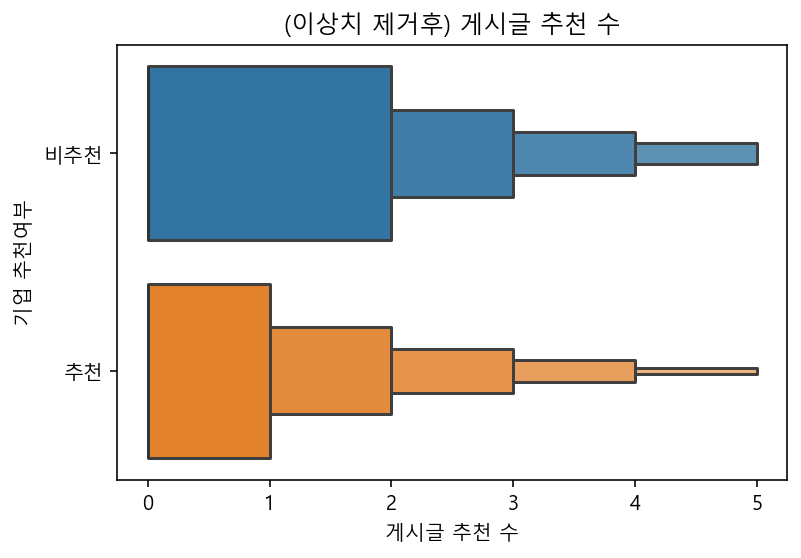

In [115]:
# 정상범위 다시 비교
sns.boxenplot(x='게시글 추천 수', data=norm,  y='기업 추천여부', order=['비추천','추천'])
plt.title('(이상치 제거후) 게시글 추천 수');

### `평균연봉그룹`

- 연봉의 범위가 넓음 (1천만원대 ~ 1억이상) 
- 임의로 3000만원으로 나눈 몫을 기준으로 연봉그룹을 생성
- 하나의 포인트(그룹 3의 승진기회 및 가능성 점수가 그룹 2보다 낮다)를 제외하고 나머지는 연봉이 높을수록 점수가 높다.

In [116]:
df = df.merge(df_company_list, how='inner', on='회사코드')

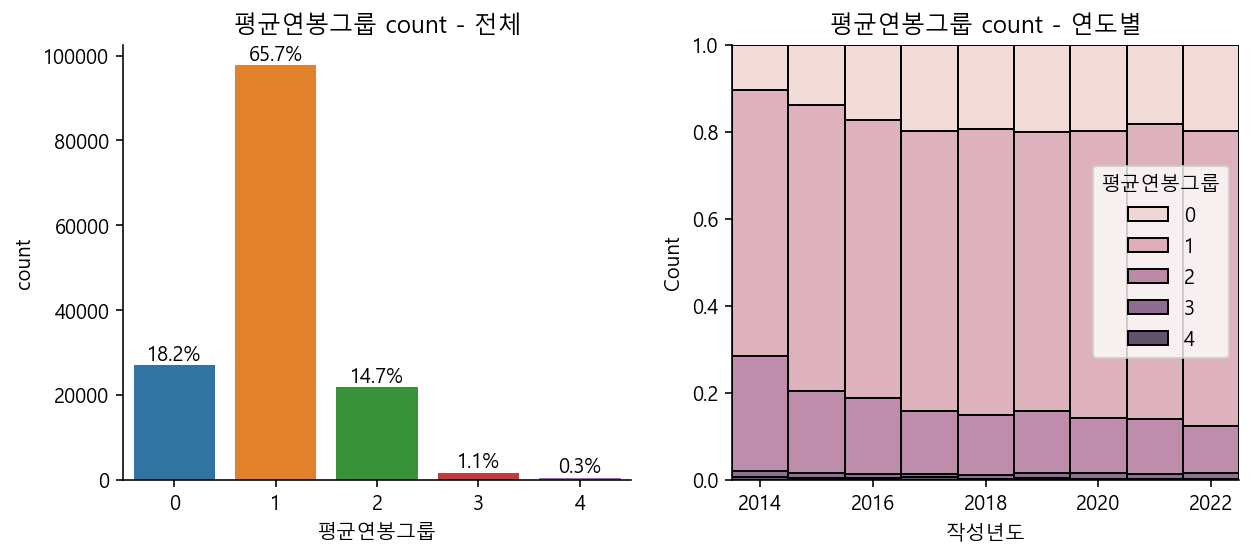

In [117]:
countplot('평균연봉그룹')

- 승진 기회 및 가능성 외에는 평균연봉이 높은 그룹이 높은 점수를 가짐

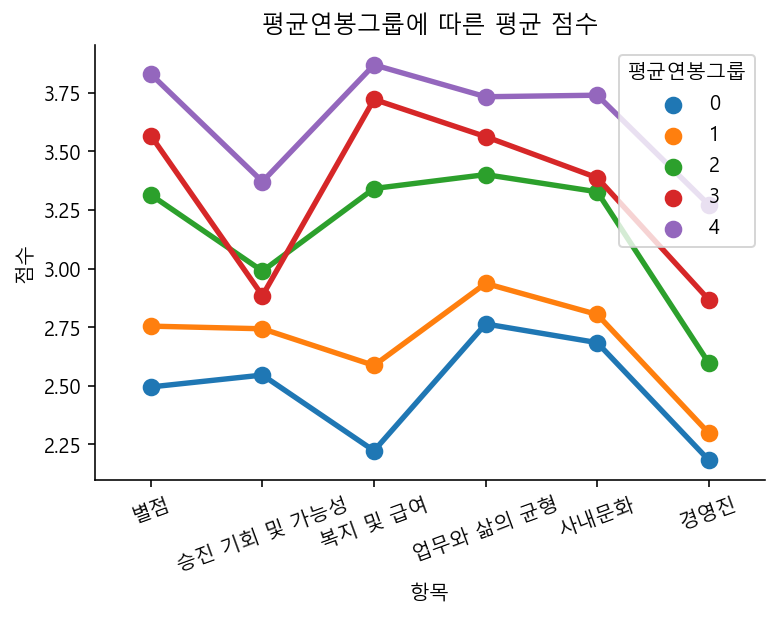

In [118]:
pointplot('평균연봉그룹')

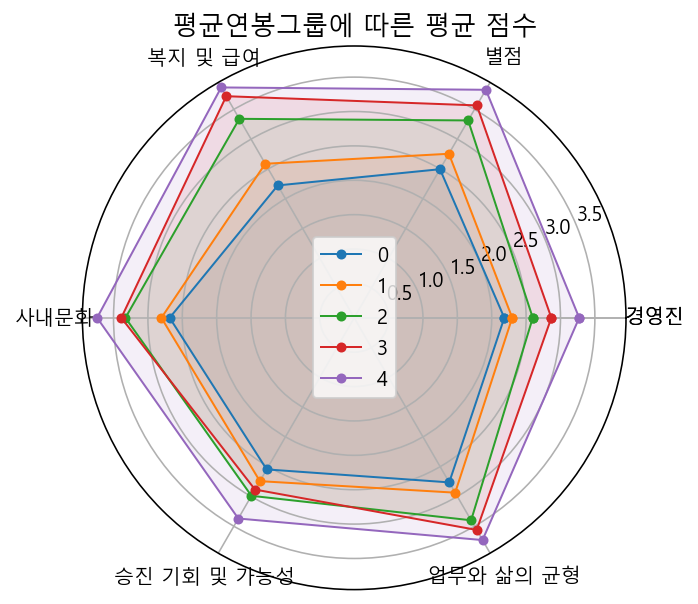

In [119]:
radarplot('평균연봉그룹')

## 리뷰 데이터(텍스트) 분석

### 전처리

In [120]:
# 전처리 함수
def clean_sentencese(text):
    pattern = '[\r|\n]'            # 개행문자 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))

    pattern = '<[^>]*>'            # html tag 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
                  
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+'    # 한글 자음, 모음 제거 
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = '([0-9])+'           # 숫자 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = '[^\w\s]'            # 특수기호 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = re.compile(r'\s+')   # 이중 space 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    return text

In [121]:
# 전처리 실행
df['총평'] = df['총평'].map(clean_sentencese)
df['장점'] = df['장점'].map(clean_sentencese)
df['단점'] = df['단점'].map(clean_sentencese)
df['경영진에 바라는 점'] = df['경영진에 바라는 점'].map(clean_sentencese)

In [122]:
df['총평']

0                                 첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사
1         영업부서는 그나마 운영이 잘되나 별 의미없는 콘텐츠 제작관련한 리소스가 너무 들어감...
2                     하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진
3                         개인적으로는 만족스럽습니다 코로나 기간동안 재택도 꽤오래함 
4                                무난히 다니기 좋은 회사입니다 나쁘지 않습니다 
                                ...                        
148654    임원들이 정말 직원들 복지 아예 신경안쓰는 것 같아요 직원들이 만족을 해야 회사가 ...
148655     정부의 지원을 받아 국내 중소기업의 홍보를 도와주는 회사정부지원에 대한 의존도가 높다 
148656                       공공기관 아래에서 중소기업을 돕는 업무는 진행하는 회사
148657                                    중소기업과 가까이 일하는 회사 
148658                           외국인 이면 들어가기 힘듭니다 마케팅 관심 필요
Name: 총평, Length: 148659, dtype: object

In [123]:
# 불용어 제거 함수
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = '것 수 사람이 너무 경우가 좀 되는 한다 함 그 많음 안 대부분 경우 조금 하는 없는 더 대한 없고 없는 기업 다른 가능 다니기 것 비해 편 않음 따라 많이 업무 하지만 그래도 없음 있으며 또한 나름 회사가 또한 좋은 좋고 좋음 좋다 그리고 때문에 다 수 있는 할 일할 회사 다닐 수 있음 있다 매우 및 등 잘 있어 있어서 있고 수 편 것 일'
    stops = list(stops.split())
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [124]:
# 불용어 제거 실행
df['총평'] = df['총평'].apply(remove_stopwords)
df['장점'] = df['장점'].apply(remove_stopwords)
df['단점'] = df['단점'].apply(remove_stopwords)
df['경영진에 바라는 점'] = df['경영진에 바라는 점'].apply(remove_stopwords)

### TF
- mecab 쓰고 싶은데 윈도우에서는 mecab 안된다고 한다. 
- kkoma는 너무 오래 걸림
- 첫 5문장 분석시 OKT보다 한나눔이 조금더 자연스럽게 명사가 끊어져서 한나눔으로 사용

In [125]:
tmp = df.copy()

#### 형태소 분석기 테스트 - 한나눔

In [126]:
hannanum=Hannanum()  
han_tmp = tmp['장점'][:100]
han_tmp

0                        사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함
1     연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...
2     리모트워크 준비 중으로 월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버틸...
3                큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임
4                     적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다 
                            ...                        
95                            입니다 배울게 있는거 같습니다 열심히 해보세요
96             자유로운 분위기는 최고임 사람들이 모난사람 없음사람 회사로는 최고인듯하다
97                         워라밸 괜찮음중간중간 눈치봐서 쉴 수있음이름 있는곳
98    보조업무라 담당업무만 마치면 개꿀전반적으로 해당업무를 배우고 싶다면 다녀봐도 괜찮을거같음
99        커머스업계의 특성을 빠르게 보고 배울수 출퇴근시간 선택제 곧 도입될 전사 재택근무
Name: 장점, Length: 100, dtype: object

In [127]:
%%time
han_tmp.apply(lambda x:hannanum.nouns(x))

Wall time: 1.94 s


0                             [카페, 안마, 사내, 복지, 칼퇴, 보장함]
1     [연차사용, 자유, 하반기, 시작, 전사, 리모트워크, 자율성, 극대화, 영업, 본...
2       [리모트워크, 준비, 중, 월, 전사, 재택근무, 예정젊, 직원들, 팀바팀, 동료들]
3                     [인센티브, 연차, 자유사용, 자유도, 수평적, 기업문화임]
4                             [적당, 워라벨, 평균적, 급여, 시간, 나]
                            ...                        
95                                           [배울게, 있는거]
96           [자유로운, 분위기, 최고, 사람, 모난사람, 없음사람, 회사, 최고, 듯]
97                      [워라밸, 괜찮음중간중간, 눈치봐, 수있음이름, 있는곳]
98                    [보조업무, 담당업무, 개꿀전반적, 해당업무, 괜찮을거같음]
99             [커머스업계, 특성, 수, 출퇴근시간, 선택제, 도입, 전사, 재택근무]
Name: 장점, Length: 100, dtype: object

#### 형태소 분석기 테스트 - Okt (구 트위터)

In [128]:
okt = Okt()
okt_tmp = tmp['장점'][:100]
okt_tmp

0                        사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함
1     연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...
2     리모트워크 준비 중으로 월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버틸...
3                큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임
4                     적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다 
                            ...                        
95                            입니다 배울게 있는거 같습니다 열심히 해보세요
96             자유로운 분위기는 최고임 사람들이 모난사람 없음사람 회사로는 최고인듯하다
97                         워라밸 괜찮음중간중간 눈치봐서 쉴 수있음이름 있는곳
98    보조업무라 담당업무만 마치면 개꿀전반적으로 해당업무를 배우고 싶다면 다녀봐도 괜찮을거같음
99        커머스업계의 특성을 빠르게 보고 배울수 출퇴근시간 선택제 곧 도입될 전사 재택근무
Name: 장점, Length: 100, dtype: object

In [129]:
%%time
okt_tmp.apply(lambda x:okt.nouns(x))

Wall time: 4.55 s


0                       [사내, 카페, 사내, 사내, 복지, 칼퇴, 보장, 함]
1     [연차, 사용, 자유, 하반기, 시작, 전사, 리, 모트, 워, 자율성, 대화, 영...
2       [리, 모트, 워, 준비, 중, 월, 전사, 재택근무, 예정, 직원, 팀바팀, 동료]
3                [인센티브, 연차, 자유, 사용, 자유도, 수평, 기업, 문화, 임]
4                                   [워, 라벨, 평균, 급여, 시간]
                            ...                        
95                                                   []
96                 [분위기, 최고, 임, 사람, 난사람, 사람, 회사, 최고, 듯]
97                        [워, 밸, 중간, 중간, 눈치, 수, 음이름, 곳]
98                 [보조, 업무, 담당, 업무, 마치, 개꿀, 전반, 해당, 업무]
99     [커머스, 업계, 특성, 보고, 출퇴근시간, 선택, 제, 곧, 도입, 전사, 재택근무]
Name: 장점, Length: 100, dtype: object

### 워드크라우드 시각화 

- 공백만 있는경우 형태소 분석기 사용시 무한루프 발생
    - 총평, 경영진에 바라는 점에 공백 존재 -> 대체 문자 삽입

In [130]:
# 총평, 
tmp[tmp['총평'] == ' ']

회사명_x   회사코드         직군 전/현직원 구분     근무지역  작성년도  별점  \
26017           야놀자  89637         기타      전직원       서울  2014   2   
43514   에스케이커뮤니케이션즈  20582  경영/기획/컨설팅      전직원       서울  2014   3   
43518   에스케이커뮤니케이션즈  20582     IT/인터넷      전직원       서울  2014   3   
119689         넥슨지티  89174        디자인      현직원  unknown  2014   5   

        승진 기회 및 가능성  복지 및 급여  업무와 삶의 균형  ...  게시글 추천 수  IT여부 수도권여부  \
26017             3        3          2  ...         1   비IT   수도권   
43514             2        3          4  ...         1   비IT   수도권   
43518             3        3          4  ...         0    IT   수도권   
119689            3        3          2  ...         2   비IT  비수도권   

             본사근무여부           회사명_y 본사위치  리뷰수 평균별점  평균연봉 평균연봉그룹  
26017          본사근무          (주)야놀자   서울  801  2.8  3633      1  
43514          본사근무  에스케이커뮤니케이션즈(주)   서울  382  3.0  5525      1  
43518          본사근무  에스케이커뮤니케이션즈(주)   서울  382  3.0  5525      1  
119689  지사근무 or 미응답         넥슨지티(주)   경기   74  3.6  5590      1  

[4 rows x 28 columns]

In [131]:
cond = tmp['총평'] == ' '
tmp['총평'] = np.where(cond, '없음', tmp['총평'])

In [132]:
# 제거 확인
tmp[tmp['총평'] == ' ']

Empty DataFrame
Columns: [회사명_x, 회사코드, 직군, 전/현직원 구분, 근무지역, 작성년도, 별점, 승진 기회 및 가능성, 복지 및 급여, 업무와 삶의 균형, 사내문화, 경영진, 총평, 장점, 단점, 경영진에 바라는 점, 1년 후 기업 전망, 기업 추천여부, 게시글 추천 수, IT여부, 수도권여부, 본사근무여부, 회사명_y, 본사위치, 리뷰수, 평균별점, 평균연봉, 평균연봉그룹]
Index: []

[0 rows x 28 columns]

In [133]:
# 공백 포함된 데이터 확인
tmp[tmp['경영진에 바라는 점'] == ' ']

회사명_x    회사코드         직군 전/현직원 구분     근무지역  작성년도  별점  승진 기회 및 가능성  \
1870         티몬   50695  경영/기획/컨설팅      현직원       서울  2015   3            2   
2674        위메프   60632      영업/제휴      전직원       서울  2020   3            3   
5526    삼성에스디에스   30162      영업/제휴      전직원       서울  2015   3            3   
5748    삼성에스디에스   30162      영업/제휴      현직원  unknown  2014   3            3   
5750    삼성에스디에스   30162     IT/인터넷      현직원       경기  2014   4            4   
...         ...     ...        ...      ...      ...   ...  ..          ...   
140820     웰게이트   60850        디자인      전직원       서울  2014   2            2   
140823     웰게이트   60850     IT/인터넷      전직원       경기  2014   3            2   
141431   한성아이티엘   48292     IT/인터넷      전직원  unknown  2014   3            3   
144342   자이트솔루션   57295     IT/인터넷      전직원  unknown  2014   3            3   
147475    웹젠온네트  314275        디자인      전직원       서울  2014   1            2   

        복지 및 급여  업무와 삶의 균형  ...  게시글 추천 수  IT여부 수도권여부       본사근무여부  \
1870          4          4  ...         0   비IT   수도권         본사근무   
2674          3          3  ...         0   비IT   수도권         본사근무   
5526          4          4  ...         1   비IT   수도권         본사근무   
5748          3          4  ...         0   비IT  비수도권  지사근무 or 미응답   
5750          4          2  ...         0    IT   수도권  지사근무 or 미응답   
...         ...        ...  ...       ...   ...   ...          ...   
140820        3          3  ...         2   비IT   수도권         본사근무   
140823        2          4  ...         0    IT   수도권  지사근무 or 미응답   
141431        3          1  ...         0    IT  비수도권  지사근무 or 미응답   
144342        2          3  ...         0    IT  비수도권  지사근무 or 미응답   
147475        3          1  ...         1   비IT   수도권  지사근무 or 미응답   

             회사명_y 본사위치   리뷰수 평균별점  평균연봉 평균연봉그룹  
1870         (주)티몬   서울  2022  2.8  4426      1  
2674        (주)위메프   서울  2003  2.6  2874      0  
5526    삼성에스디에스(주)   서울  1801  3.5  8296      2  
5748    삼성에스디에스(주)   서울  1801  3.5  8296      2  
5750    삼성에스디에스(주)   서울  1801  3.5  8296      2  
...            ...  ...   ...  ...   ...    ...  
140820     웰게이트(주)   서울    40  3.1  3601      1  
140823     웰게이트(주)   서울    40  3.1  3601      1  
141431   (주)한성아이티엘   서울    39  3.6  3956      1  
144342   (주)자이트솔루션   서울    35  2.9  3365      1  
147475    (주)웹젠온네트   경기    31  2.7  4078      1  

[236 rows x 28 columns]

In [134]:
# 제거
cond = tmp['경영진에 바라는 점'] == ' '
tmp['경영진에 바라는 점'] = np.where(cond, '없음', tmp['경영진에 바라는 점'])

In [135]:
# 제거 확인
tmp[tmp['경영진에 바라는 점'] == ' ']

Empty DataFrame
Columns: [회사명_x, 회사코드, 직군, 전/현직원 구분, 근무지역, 작성년도, 별점, 승진 기회 및 가능성, 복지 및 급여, 업무와 삶의 균형, 사내문화, 경영진, 총평, 장점, 단점, 경영진에 바라는 점, 1년 후 기업 전망, 기업 추천여부, 게시글 추천 수, IT여부, 수도권여부, 본사근무여부, 회사명_y, 본사위치, 리뷰수, 평균별점, 평균연봉, 평균연봉그룹]
Index: []

[0 rows x 28 columns]

- 형태소 분석 - 명사추출

In [137]:
# # %%time
# # 약 40분 소요 - 최초 1회 실시

# tmp['총평'] = tmp['총평'].apply(lambda x:hannanum.nouns(x))
# tmp['장점'] = tmp['장점'].apply(lambda x:hannanum.nouns(x))
# tmp['단점'] = tmp['단점'].apply(lambda x:hannanum.nouns(x))
# tmp['경영진에 바라는 점'] = tmp['경영진에 바라는 점'].apply(lambda x:hannanum.nouns(x))

# #불필요 컬럼 제거후 내보내기
# tmp = tmp.drop(['회사명_y','리뷰수','본사위치','평균연봉','평균별점','게시글 추천 수','회사코드'], axis=1).rename(columns={'회사명_x':'회사명'})
# tmp.to_csv('./input/df_text_processed.csv')

In [149]:
# 불러오기
df_text = pd.read_csv('./input/df_text_processed.csv', index_col=0)

In [150]:
df_text['총평'] = df_text['총평'].apply(clean_sentencese)
df_text['장점'] = df_text['장점'].apply(clean_sentencese)
df_text['단점'] = df_text['단점'].apply(clean_sentencese)
df_text['경영진에 바라는 점'] = df_text['경영진에 바라는 점'].apply(clean_sentencese)

In [157]:
# 불용어 제거 함수
def stopwords(text):
    tokens = text.strip().split(' ')
#     tokens = list(text)
    stops = '것 수 사람이 너무 경우가 심함 좀 되는 한다 함 그 많음 안 대부분 경우 조금 하는 없는 더 대한 없고 없는 기업 다른 가능 다니기 것 비해 편 않음 따라 많이 업무 하지만 그래도 없음 있으며 또한 나름 회사가 또한 좋은 좋고 좋음 좋다 그리고 때문에 다 수 있는 할 일할 회사 다닐 수 있음 있다 매우 및 등 잘 있어 있어서 있고 수 편 것 일'
    stops = list(stops.split(' '))
    
    meaningful_words = [w for w in tokens if not w in stops]
    meaningful_words = [w for w in meaningful_words if len(w) > 1 and len(w) < 6]
    return meaningful_words

In [158]:
df_text['총평'] = df_text['총평'].apply(stopwords)
df_text['장점'] = df_text['장점'].apply(stopwords)
df_text['단점'] = df_text['단점'].apply(stopwords)
df_text['경영진에 바라는 점'] = df_text['경영진에 바라는 점'].apply(stopwords)

- 항목간의 차이가 크게 보이지 않는다..
    - 어떻게 하면 텍스트 데이터를 잘 활용할 수 있을지? 

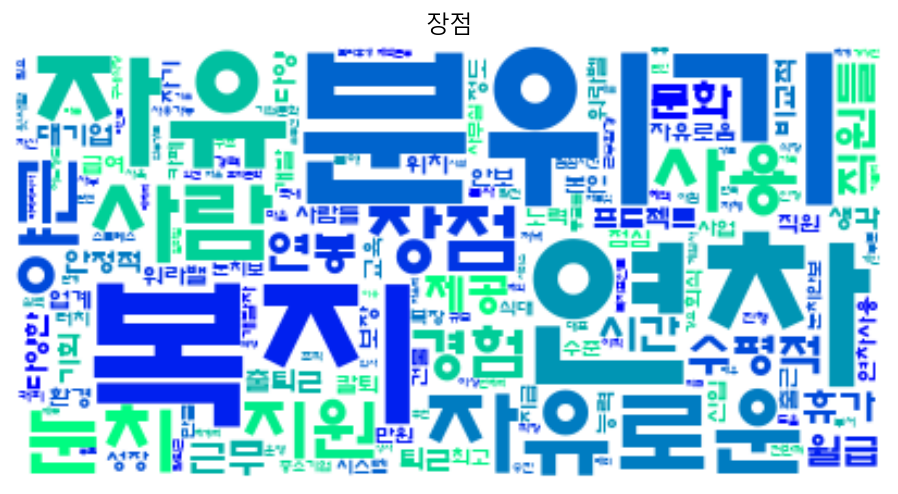

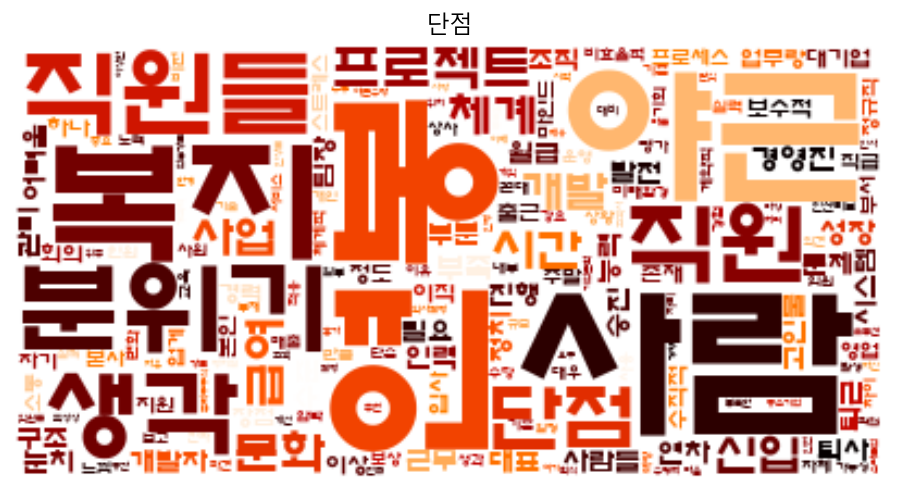

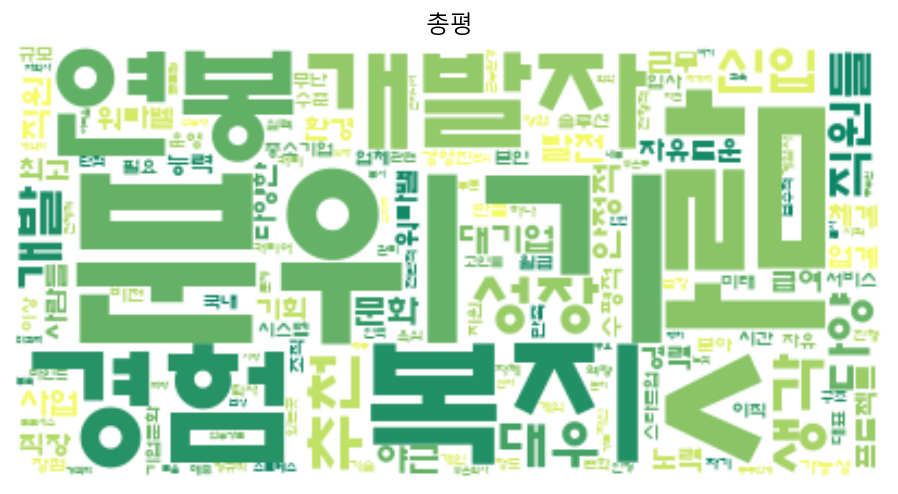

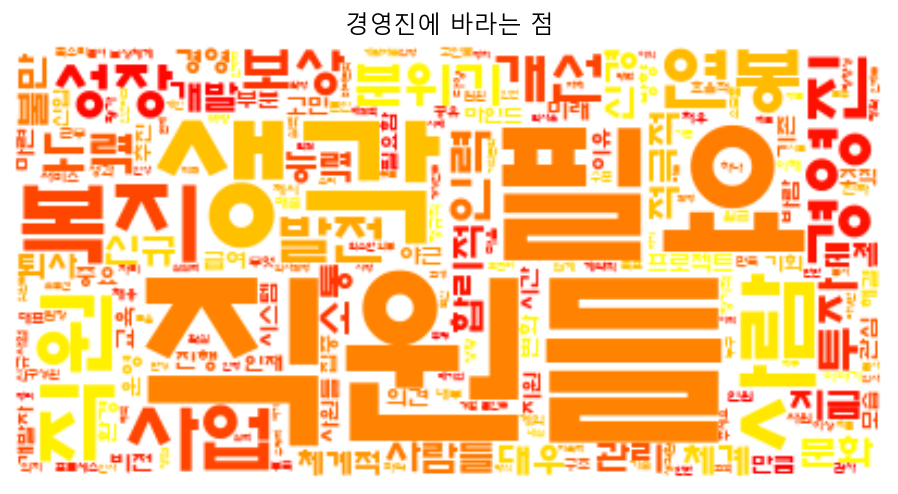

In [163]:
arr_group = {'IT여부':'IT', '전/현직원 구분':'전직원', '수도권여부':'수도권', 
             '1년 후 기업 전망':'성장', '기업 추천여부':'추천'}

cat = {'장점':'winter','단점':'gist_heat','총평':'summer','경영진에 바라는 점':'autumn'}


for cat, col in cat.items():

    
    plt.figure(figsize=(8,4))
    변수 = Counter(list(itertools.chain(*list(df_text[cat]))))
    wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap=col).generate_from_frequencies(변수)
    
    plt.axis('off') # 그래프 축 제거
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{cat}')
    plt.show()
        

# 고찰
- 형태소 분석기의 stemming 기능을 써서 조금더 자연스럽게 사용할 수 있겠다.
  - 형태소 분석기로 명사, 동사 먼저 추출한다음(시간도 오래 걸리고) 불용어 처리를 나중에 한다.
    - 지금은 전처리, 불용어 처리 먼저하고 바로 토큰화 -> 시각화

- 텍스트 데이터 항목4가지의 키워드가 서로 비슷하다.
- 어떻게 하면 텍스트 데이터를 조금 더 잘 활용할 수 있을지 생각 필요